<a href="https://colab.research.google.com/github/samuramirez/cellmigration/blob/master/segmentationQC_trackingQC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mount Google Drive (Colab can see Drive files) and authenticate so that we can interact with GCP via SDK

In [1]:
in_colab = True;
try:
  from google.colab import drive
  mount_location = '/content/drive'
  drive.mount(mount_location,force_remount=True);
  
  from pathlib import Path
  import sys
  libraries_path =  "MyDrive" #@param {type:"string"}
  colab_libraries_path = Path(mount_location)/libraries_path
  print("c_libraries_path:",colab_libraries_path)
  sys.path.insert(0,str(colab_libraries_path)); #add google drive's libraries to path
  
  from google.colab import auth
  #This allows SDK to see and edit Google Drive files
  #SDK is required to interact with GCP
  auth.authenticate_user()
except ImportError as ie:
  print("google not found; assuming non-colab execution")
  print(ie);
  in_colab = False;
except Exception as e:
  print("google authentication failed, please retry")
  raise e



Mounted at /content/drive
c_libraries_path: /content/drive/MyDrive


# Global Parameters and Setup


### General library imports

In [2]:
!pip install -Uqq scikit-image
!pip install -Uqq tifffile
!pip install -Uqq mediapy
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.1/216.1 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.8 MB/s eta 0:00:00


In [3]:
from __future__ import annotations
import numpy as np
from ipywidgets import interact, widgets, Layout
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.io import imread, imsave, imshow
from skimage import data, filters, measure, morphology, util
from skimage.exposure import rescale_intensity
from skimage.transform import rescale, resize, downscale_local_mean
from pathlib import Path
from fastprogress.fastprogress import progress_bar,master_bar
from enum import Enum
import tifffile
import pandas as pd
import cv2
import ntpath
import os
import time
import pickle
import re
import copy
import scipy
import builtins
import shutil
from itertools import starmap
from functools import partial
import random
import csv
from scipy import ndimage
import numpy as np
from ipywidgets import interact, widgets, Layout
from IPython.utils.io import capture_output
import matplotlib.pyplot as plt
from typing import Dict, DefaultDict, Tuple, List, Union

import itertools
import math

import mediapy as media
import matplotlib.pyplot as plt
import numpy as np

#Get from Drive the folder libraries
from libraries.filter_cells_fns import remove_multiple_nuclei_cells, remove_large_objects, remove_touching_edge
from libraries.centers import get_centers, fill_label_holes, normalize
from libraries.qc_functions import apply_qc
# from libraries.centroidtracker import CentroidTracker
from libraries.centroidtracker_unstable import CentroidTracker


## Auxiliary Helper Functions 

### Progress Bar

In [4]:
if not in_colab:
    
    from tqdm import tqdm
    def progress_bar(*args,parent=None,**kwargs):
        return tqdm(*args,leave=parent is not None,**kwargs);

### Path Formatting

In [5]:
class SafeDict(dict):
    def __missing__(self, key):
        return '{' + key + '}'

def format_path(path:Union[str,Path],collection:Union[bool,None]=None,movie:Union[int,None]=None,experiment:Union[str,None]=None,**kwargs):
  is_path = isinstance(path,Path);
  path = str(path);
  map = SafeDict();
  if collection is not None:
    map["collection"] = "using" if collection else "no";
  if movie is not None:
    map["movie"] = str(movie);
  if experiment is not None:
    map["experiment"] = experiment;
  map.update(kwargs);
  result = path.format_map(map);
  if is_path:
    result = Path(result);
  return result;
  

## Input Paths and Settings

### Colab Parameters

In [6]:
#@markdown where various folders are on disk, you probably never need to change these

local_folder = "content" #@param {type:"string"};
local_folder:Path = Path(local_folder);

#where files and folders are stored when downloaded from GCP
gcp_transfer_folder = "gcp_transfer" #@param {type:"string"}
gcp_transfer_folder:Path = Path(gcp_transfer_folder)

#where files and folders are stored locally that should be cleared between operations
temp_folder = "temp" #@param {type:"string"}
temp_folder:Path = Path(temp_folder)

if not os.path.exists(gcp_transfer_folder):
  os.mkdir(gcp_transfer_folder);

if not os.path.exists(temp_folder):
  os.mkdir(temp_folder);

### Experimental Parameters

In [7]:
#@markdown Experiment Name (will be incorporated into output file and folder names)
experiment = "2023.1.26 OptoITSN Test 41" #@param {type:"string"}


#@markdown Analysis folder: all output analysis data will be output to gs://{analysis output folder}/{experiment name}
analysis_output_folder = "optotaxisbucket/Segmentation Analysis" #@param {type:"string"}
analysis_output_folder:Path = Path(analysis_output_folder)
gcp_analysis_output_folder:Path = analysis_output_folder/experiment;
local_analysis_output_folder:Path = gcp_transfer_folder/analysis_output_folder.name/experiment;
if not os.path.exists(local_analysis_output_folder):
  os.makedirs(local_analysis_output_folder);
del analysis_output_folder;

if "gcp_images" in locals():
  prev_im = gcp_images
else:
  prev_im = None;

if "gcp_cell_masks" in locals():
  prev_cm = gcp_cell_masks
else:
  prev_cm = None;

if "gcp_nuc_masks" in locals():
  prev_nm = gcp_nuc_masks
else:
  prev_nm = None;

#@markdown For any of the following paths, if you put {experiment} in the string, it'll replace that with the name of the experiment for convenience:

#@markdown Location of experiment images on the GCP bucket. Can be a folder, a .zip file, or a tif stack; If a zip file, should contain a folder of the same name as the zip file. Exclude the 'gs://' from the path. 
gcp_images_s:str = "optotaxisbucket/movies/{experiment}/{experiment}" #@param {type:"string"}
gcp_images_s = format_path(gcp_images_s,experiment=experiment).replace("gs://","");
# print(gcp_images);
gcp_images:Path = Path(gcp_images_s);

#@markdown Location of segmented cell-area masks on the GCP bukcet. Can be a folder, a .zip file, or a tif stack; If a zip file, should contain a folder of the same name as the zip file. Exclude the 'gs://' from the path.
gcp_cell_masks_s:str = "optotaxisbucket/movie_segmentation/{experiment}/segmentation_output_masks/Cell.zip" #@param {type:"string"}
gcp_cell_masks_s = format_path(gcp_cell_masks_s,experiment=experiment).replace("gs://","");
gcp_cell_masks:Path = Path(gcp_cell_masks_s);

#@markdown Location of segmented nucleus-area masks on the GCP bukcet. Can be a folder, a .zip file, or a tif stack; If a zip file, should contain a folder of the same name as the zip file. Exclude the 'gs://' from the path.
gcp_nuc_masks_s = "optotaxisbucket/movie_segmentation/{experiment}/segmentation_output_masks/Nucleus.zip" #@param {type:"string"}
gcp_nuc_masks_s = format_path(gcp_nuc_masks_s,experiment=experiment).replace("gs://","");
gcp_nuc_masks:Path = Path(gcp_nuc_masks_s);

images_changed,cell_masks_changed,nuc_masks_changed = [False,False,False];
if gcp_images != prev_im:
  images_changed = True;
if gcp_cell_masks != prev_cm:
  cell_masks_changed = True;
if gcp_nuc_masks != prev_nm:
  nuc_masks_changed = True;

test = gcp_images;
if (not str(test).lower().endswith((".zip",".tif",".tiff"))): #directory
  test = str(test) + '/*'
valid = !gsutil -q stat "gs://{test.as_posix()}"; echo $?
if (valid[0] == '1'): #images dir does not exist
  raise Exception(f"Error: Images dir gs://{gcp_images.as_posix()} does not exist in bucket. To ignore this error simply run the succeeding cells.")

test = gcp_cell_masks;
if (not str(test).lower().endswith((".zip",".tif",".tiff"))): #directory
  test = str(test) + '/*'
valid = !gsutil -q stat "gs://{test.as_posix()}"; echo $?
if (valid[0] == '1'): #cell dir does not exist
  raise Exception(f"Error: Cell masks dir gs://{gcp_cell_masks.as_posix()} does not exist in bucket. To ignore this error simply run the succeeding cells.")

test = gcp_nuc_masks;
if (not str(test).lower().endswith((".zip",".tif",".tiff"))): #directory
  test = str(test) + '/*'
valid = !gsutil -q stat "gs://{test.as_posix()}"; echo $?
if (valid[0] == '1'): #nuc dir does not exist
  raise Exception(f"Error: Nucleus masks dir gs://{gcp_nuc_masks.as_posix()} does not exist in bucket. To ignore this error simply run the succeeding cells.")


print("Successfully verified inputs - all folders and files exist in the bucket")

Successfully verified inputs - all folders and files exist in the bucket


## Global helper function setup

### File Management

In [8]:
#keyword should be unique for each type of object pulled from the cloud to avoid collisions
def _fetch_image_files(in_path:Path,keyword:str,overwrite:bool)->Path: ##should not be called outside of other helper functions, will always overwrite
  # print(in_path);
  is_file = str(in_path).lower().endswith(('.zip','.tif','.tiff'));
  destination = gcp_transfer_folder/keyword/experiment;
  if not(os.path.exists(destination)):
    os.makedirs(destination);
  # copy_out = Path(destination)/in_path.name;
  command_output = None;
  if overwrite or len(os.listdir(destination)) == 0:
    if is_file:
      command_output = !gsutil -m cp -r "gs://{in_path.as_posix()}" "{destination.as_posix()}"
    else:
      command_output = !gsutil -m rsync -r "gs://{in_path.as_posix()}" "{destination.as_posix()}"
  if (command_output is not None and command_output[0].startswith("CommandException")):
    raise RuntimeError(f"Error while downloading {keyword} from bucket: " + '\n'.join(command_output));
  elif len(os.listdir(destination)) == 0:
    raise RuntimeError("Error: downloading failed for an unknown reason; downloading command_output:",command_output);
  # print(in_path.suffix);
  if (not is_file):
    return destination; #we're done
  else:
    destination = destination/in_path.name;
  if (in_path.suffix == '.zip'):
    out_path = destination.with_suffix('');
    # print(copy_out);
    command_output = None;
    if (overwrite or not os.path.exists(out_path)):
      command_output = !unzip -o "{destination}" -d "{destination.parent}"
    # print(command_output);
    if (command_output is not None and command_output[0].startswith("CommandException")):
      raise RuntimeError(f"Error while unzipping {keyword}: " + '\n'.join(command_output));
    elif not os.path.exists(out_path):
      raise RuntimeError(f"Error: zip file {destination} does not contain folder {destination.with_suffix('')}");
    return out_path;
  elif (in_path.suffix.lower().startswith('.tif')):
    raise NotImplementedError("unstacking TIF files not yet supported");
  else:
    raise NameError("Invalid input suffix, input validation should have caught this >:(");  

In [9]:
def fetch_images(force_overwrite=False)->Path:
  global images_changed;
  out = _fetch_image_files(Path(gcp_images),'images',images_changed or force_overwrite);
  images_changed = False;
  return out;

def fetch_cell_masks(force_overwrite=False)->Path:
  global cell_masks_changed;
  out = _fetch_image_files(Path(gcp_cell_masks),'cellmasks',cell_masks_changed or force_overwrite);
  cell_masks_changed = False;
  return out;

def fetch_nuc_masks(force_overwrite=False)->Path:
  global nuc_masks_changed;
  out = _fetch_image_files(Path(gcp_nuc_masks),'nucmasks',nuc_masks_changed or force_overwrite);
  nuc_masks_changed = False;
  return out;

In [10]:
def push_analysis(): #VERY IMPORTANT: THIS METHOD RELIES ON local_analysis_output_folder BEING ONE-DEPTH
  s = !gsutil -m rsync -r "{local_analysis_output_folder.as_posix()}" "gs://{gcp_analysis_output_folder.as_posix()}"
  if (s[0].startswith("CommandException")):
    raise RuntimeError("error while uploading analysis folder: " + '\n'.join(s));

def fetch_analysis():
  if not os.path.exists(local_analysis_output_folder):
    os.makedirs(local_analysis_output_folder);
  t = !gsutil ls "gs://{gcp_analysis_output_folder.as_posix()}"
  if (t[0].startswith("CommandException")):
    print("analysis folder not found in bucket, skipping analysis fetch:");
    print('\n'.join(t));
    return;
  s = !gsutil -m rsync -r "gs://{gcp_analysis_output_folder.as_posix()}" "{local_analysis_output_folder.as_posix()}"
  if (s[0].startswith("CommandException")):
    raise RuntimeError("error while downloading analysis folder: " + '\n'.join(s));

In [11]:
def on_rm_error( func, path, exc_info):
    # path contains the path of the file that couldn't be removed
    # let's just assume that it's read-only and unlink it.
    os.chmod( path, stat.S_IWRITE )
    # os.unlink( path )

def cleardir(dir): #clears all files in dir without deleting dir
  for f in os.scandir(dir):
    # f = os.path.join(dir,f)
    if os.path.isdir(f): shutil.rmtree(f,onerror=on_rm_error); #just in case
    else: os.remove(f);

### Cell filtering

In [12]:
def getcells(filecell:Union[Union[str, bytes, os.PathLike],np.ndarray],filenuc:Union[Union[str, bytes, os.PathLike],np.ndarray],parameters,return_metrics):
  #membrane
  maskMem:np.ndarray=imread(filecell) if not isinstance(filecell,np.ndarray) else filecell;
  # print(np.min(maskmem));
  # print(np.max(maskmem));
  maskMem[maskMem>0]=1
  #fill holes
  maskMem=ndimage.binary_fill_holes(maskMem).astype(int);

  #nuclei
  maskNuc:np.ndarray = imread(filenuc) if not isinstance(filenuc,np.ndarray) else filenuc;
  maskNuc[maskNuc>0]=1

  #label different objectes in masks
  maskMem,numMem = measure.label(maskMem,return_num=True)
  maskNuc,numNuc = measure.label(maskNuc,return_num=True);

  if numMem < 255 and numNuc < 255:
    maskMem = maskMem.astype('uint8');
    maskNuc = maskNuc.astype('uint8');
  else:
    maskMem = maskMem.astype('uint16');
    maskNuc = maskNuc.astype('uint16');
  
  #FILTERS
  if parameters['remove_cells_touching_edge'] == True:
    maskMem=remove_touching_edge(maskMem)
  
  if parameters['filter_cell_size'] == True:
    maskMem = morphology.remove_small_objects(maskMem, parameters['minareacell'],in_place=True)       
    maskMem = remove_large_objects(maskMem, parameters['maxareacell'])
  
  if parameters['filter_nuc_size'] == True:
    maskNuc = morphology.remove_small_objects(maskNuc, parameters['minareanuc'],in_place=True)       
  
  if parameters['remove_multi_nuclei_cells'] == True:
    maskMem = remove_multiple_nuclei_cells(maskMem,maskNuc)

  if (return_metrics):
    #if there are cells get metrics
    ids=list(range(1,numMem+1));
    #remove 0 (background) from ids
    # ids.remove(0)
    if len(ids) > 0:
      cellsmetrics = measure.regionprops_table(maskMem, properties=('label','area'))
      cellsmetrics=pd.DataFrame(cellsmetrics)
      if (len(cellsmetrics['label']) > 0 and len(cellsmetrics['area']) > 0):

        #GET CENTERS
        #get labels
        labels=cellsmetrics['label']    
        #Because 'label' was copied from the table, after computing the centers 
        #and concatenating them to the table they should be in the right order
        
        centers=get_centers(maskMem,'approximate-medoid',labels, False)
        #add centers to cell properties
        appmedoid=pd.DataFrame(data=np.asarray(centers),columns=['approximate-medoidx','approximate-medoidy'])
        cellsmetrics=pd.concat([cellsmetrics,appmedoid],1)
        
        centers=get_centers(maskMem,'centroid',labels, False)
        #add centers to cell properties
        centroid=pd.DataFrame(data=np.asarray(centers),columns=['centroidx','centroidy'])
        cellsmetrics=pd.concat([cellsmetrics,centroid],1)
      
        


    else:
      cellsmetrics=pd.DataFrame();
    return cellsmetrics, maskMem, maskNuc 
  else:
    return maskMem,maskNuc
 

# Input Movie Reading Parameters

### Copy images and masks from GCP to Colab (May take some time, zip folders in GCP to speed this up)

In [ ]:
with capture_output:
  folderimages = fetch_images();
  foldermasks = fetch_cell_masks();
try:
  with capture_output:
    foldernucmasks = fetch_nuc_masks();
except Exception as e:
  foldernucmasks = None;
  raise Exception("Warning: nucleus masks not found. If you wish to visualize anyway, keep running cells in Segmentation quality control, but cell filtering will be disabled and settings will not save") from e;

Copying gs://optotaxisbucket/movies/2023.2.3 OptoITSN Test 44/2023.2.3 OptoITSN Test 44/p_s2_t265.TIF...
Copying gs://optotaxisbucket/movies/2023.2.3 OptoITSN Test 44/2023.2.3 OptoITSN Test 44/p_s2_t267.TIF...
Copying gs://optotaxisbucket/movies/2023.2.3 OptoITSN Test 44/2023.2.3 OptoITSN Test 44/p_s2_t268.TIF...
Copying gs://optotaxisbucket/movies/2023.2.3 OptoITSN Test 44/2023.2.3 OptoITSN Test 44/p_s2_t269.TIF...
Copying gs://optotaxisbucket/movies/2023.2.3 OptoITSN Test 44/2023.2.3 OptoITSN Test 44/p_s2_t27.TIF...
Copying gs://optotaxisbucket/movies/2023.2.3 OptoITSN Test 44/2023.2.3 OptoITSN Test 44/p_s2_t270.TIF...
Copying gs://optotaxisbucket/movies/2023.2.3 OptoITSN Test 44/2023.2.3 OptoITSN Test 44/p_s2_t271.TIF...
Copying gs://optotaxisbucket/movies/2023.2.3 OptoITSN Test 44/2023.2.3 OptoITSN Test 44/p_s2_t272.TIF...
Copying gs://optotaxisbucket/movies/2023.2.3 OptoITSN Test 44/2023.2.3 OptoITSN Test 44/p_s2_t273.TIF...
Copying gs://optotaxisbucket/movies/2023.2.3 OptoITSN Te

In [ ]:
fetch_analysis();

analysis folder not found in bucket, skipping analysis fetch


### Initialize parameters for reading images and upload (select movies and frame ranges)

In [ ]:
#@markdown ## Identify movies and frames in input image folder (code hidden)
imagenames=[f for f in os.listdir(foldermasks) if f.endswith('.TIF')]
#Get list of movies
movies = [int(re.findall(r"s(\d+).", imagenames[i])[0]) for i in range(len(imagenames)) ]
#get set of unique elements
movies = list(set(movies))
#sort
movies.sort()
print("movies detected in experiment:",movies);
#Get frame numbers and show the largest number
frames = {m:[] for m in movies};
for name in imagenames:
  match = re.findall(r"s(\d+)_t(\d+).", name)[0];
  # print(match);
  frames[int(match[0])].append(int(match[1]));
for m in movies:
  frames[m].sort();
# nframes={m:max(f) for m,f in frames.items()}
# print("frames detected per movie:",nframes);
print(frames);
# imagenames[0]
basename= re.findall(r"(.*)_s",imagenames[0])[0]
print("image basename:",basename);

movies detected in experiment: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 20

In [ ]:
#@markdown ## Set movie frame ranges
use_frame_range = False #@param {"type":"boolean"}

#@markdown Enter frame ranges: dictionary of movie:[rangemin,rangemax] items in raw python syntax
frame_ranges:Dict =  {4:(0,470)}#@param {"type":"raw"}

#@markdown whether to exclude specific movies from the list of movies
do_exclude_movies = True #@param {"type":"boolean"}

from typing import Iterable
#@markdown list of movies to exclude
exclude_movies:Iterable = [1] #@param {"type":"raw"}

if do_exclude_movies:
  [movies.remove(m) for m in exclude_movies]
  print("updated movies:",movies)

if use_frame_range:
  new_frames = {m:frames[m] if m not in frame_ranges else list(range(max(min(frames[m]),frame_ranges[m][0]),1+min(max(frames[m]),frame_ranges[m][1]))) for m in movies};
  assert set(new_frames.keys()) == set(movies);
  frames = new_frames;
  print("updated frame ranges:",frames)


updated movies: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


### Input and Save Cell filtering parameters

In [ ]:
#@markdown ## Input and save cell filtering parameters


#@markdown #### Cell location parameters

remove_cells_touching_edge = True #@param {type:"boolean"}

remove_multi_nuclei_cells = True #@param {type:"boolean"}


#@markdown #### Set size bounds (number of pixels)

filter_cell_size = True #@param {type:"boolean"}


#minarea=600
#maxarea=3200
#nucminarea=21*pixelsize**2

minareacell=150 #@param {type:"integer"}
maxareacell=15000 #@param {type:"integer"}

filter_nuc_size = False #@param {type:"boolean"}
minareanuc=5 #@param {type:"integer"}

reading_cells_parameters = {
    'experiment':experiment, 
    'basename':basename,
    'movies':movies,
    'frames':frames,
    'remove_cells_touching_edge':remove_cells_touching_edge,
    'remove_multi_nuclei_cells':remove_multi_nuclei_cells,
    'filter_cell_size':filter_cell_size,
    'minareacell':minareacell,
    'maxareacell':maxareacell,
    'filter_nuc_size':filter_nuc_size,
    'minareanuc':minareanuc,
    # 'img_min_intensity':minintensity,
    # 'img_max_intensity':maxintensity
              }

if not os.path.exists(local_analysis_output_folder):
  os.makedirs(local_analysis_output_folder)

with open(local_analysis_output_folder/'reading_cells_parameters.pkl', 'wb') as handle:
    pickle.dump(reading_cells_parameters, handle)
push_analysis();

# [Optional] Segmentation Visualization - Segmentation quality control

### Copy images and masks from GCP to Colab (May take some time, zip folders in GCP to speed this up)

In [ ]:
folderimages = fetch_images();
foldermasks = fetch_cell_masks();
try:
  foldernucmasks = fetch_nuc_masks();
except Exception as e:
  foldernucmasks = None;
  raise Exception("Warning: nucleus masks not found. If you wish to visualize anyway, keep running cells in Segmentation quality control, but cell filtering will be disabled and settings will not save") from e;

Copying gs://optotaxisbucket/movies/2023.2.3 OptoITSN Test 44/2023.2.3 OptoITSN Test 44/p_s6_t370.TIF...
Copying gs://optotaxisbucket/movies/2023.2.3 OptoITSN Test 44/2023.2.3 OptoITSN Test 44/p_s6_t371.TIF...
Copying gs://optotaxisbucket/movies/2023.2.3 OptoITSN Test 44/2023.2.3 OptoITSN Test 44/p_s6_t372.TIF...
Copying gs://optotaxisbucket/movies/2023.2.3 OptoITSN Test 44/2023.2.3 OptoITSN Test 44/p_s6_t373.TIF...
Copying gs://optotaxisbucket/movies/2023.2.3 OptoITSN Test 44/2023.2.3 OptoITSN Test 44/p_s6_t374.TIF...
Copying gs://optotaxisbucket/movies/2023.2.3 OptoITSN Test 44/2023.2.3 OptoITSN Test 44/p_s6_t375.TIF...
Copying gs://optotaxisbucket/movies/2023.2.3 OptoITSN Test 44/2023.2.3 OptoITSN Test 44/p_s6_t378.TIF...
Copying gs://optotaxisbucket/movies/2023.2.3 OptoITSN Test 44/2023.2.3 OptoITSN Test 44/p_s6_t376.TIF...
Copying gs://optotaxisbucket/movies/2023.2.3 OptoITSN Test 44/2023.2.3 OptoITSN Test 44/p_s6_t377.TIF...
Copying gs://optotaxisbucket/movies/2023.2.3 OptoITSN T

In [ ]:
fetch_analysis();
with open(local_analysis_output_folder/"reading_cells_parameters.pkl",'rb') as f:
  reading_cells_parameters = pickle.load(f);

### Fetch Analysis, Load Movie Reading Parameters

In [ ]:
fetch_analysis();

with open(local_analysis_output_folder/"reading_cells_parameters.pkl",'rb') as f:
  reading_cells_parameters = pickle.load(f);

basename = reading_cells_parameters['basename'];

## Load separate cell masks and nucleus masks and visualize together

In [ ]:
#@markdown ##Compute Movie Frames

#@markdown Which movie to view
movie=6 #@param {type:"integer"}
if movie not in reading_cells_parameters['movies']:
  raise Exception(f"invalid movie number, check that it's in range hasn't been excluded from the experiment.\nMovie number {movie} is not in experiment with movies: {movies}")

#@markdown Frame downsample rate (how often a frame is shown); increase this number for a faster processing time but less fine time-resolution
frspace=3 #@param {type:"integer"}

#@markdown Nucleus intensity for combined image (between 0 and 1)
mfrac=0.7 #@param {type:"number"}

#@markdown how much to resize the image by (the more downscaled, the faster the playing but the less the resolution)
downfrac = 0.5 #@param {type:"number"};

#@markdown whether to show the splitting sections on the image
show_splitting_sections = False #@param{type:"boolean"}

splitting_overlay_opacity = 0.3;
splitting_overlay_contrast = 1;

#@markdown ### If showing splitting sections, input the splitting parameters used
#@markdown x_slices, y_slices are how many pieces in each direction the image is split into
x_slices = 5 #@param {type:"integer"}
y_slices =  5 #@param {type:"integer"}
#@markdown dx, dy are the extra context around the segmented center in both directions
dx =  42#@param {type:"integer"}
dy =  32#@param {type:"integer"}
#@markdown x and y crop are how much to straight remove from the image to make the sizes able to be subdivided nicely
x_crop = 0 #@param {type:"integer"}
y_crop = 0 #@param {type:"integer"}

context_bounds = [dy,dx]*2 #assuming x and y symmetrical, not always true -- fix?
crop = [y_crop,x_crop]*2 #both of these are negative y, negative x, positive y, positive x
splitting_overlay = None;
if show_splitting_sections:
  sh = imread(folderimages/[f for f in os.listdir(folderimages) if f.endswith(".TIF")][0]).shape;
  im = np.ndarray((sh[0],sh[1]));
  im.fill(0);
  print(im.shape);
  M = (im.shape[0]-context_bounds[0]-context_bounds[2]-crop[0]-crop[2])/y_slices;
  N = (im.shape[1]-context_bounds[1]-context_bounds[3]-crop[1]-crop[3])/x_slices;
  print(M,N);
  if int(M) != M or int(N) != N:
    raise Exception(f"ERROR: invalid image splitting parameters for image of shape {im.shape}");
  M = int(M)
  N = int(N)
  tiles = [im[y-context_bounds[0]:y+M+context_bounds[2],x-context_bounds[1]:x+N+context_bounds[3]] 
    for y in range(context_bounds[0]+crop[0],im.shape[0]-crop[0]-crop[2]-context_bounds[0]-context_bounds[2],M) 
    for x in range(context_bounds[1]+crop[1],im.shape[1]-crop[1]-crop[3]-context_bounds[1]-context_bounds[3],N)];

  outtiles = [];
  for i,c in enumerate(tiles):
    tile = c.copy();
    if (i % 2 == 0):
      tile.fill(splitting_overlay_contrast);
    outtiles.append(tile);
  tiles = outtiles;

  stitchMasks = [];
  for i,m in enumerate(tiles):
    x = i // y_slices;
    y = i % x_slices;
    imBounds = [crop[0]+context_bounds[0] if x != 0 else 0,m.shape[0]-crop[2]-context_bounds[2] if x != x_slices-1 else m.shape[0],crop[1]+context_bounds[1] if y!= 0 else 0 ,m.shape[1]-crop[3]-context_bounds[3] if y != y_slices - 1 else m.shape[1]];
    stitchMasks.append(m[imBounds[0]:imBounds[1],imBounds[2]:imBounds[3]]);
  splitting_overlay = np.concatenate([np.concatenate(stitchMasks[i*x_slices:(i+1)*x_slices],axis=1) for i in range(y_slices)]);
  print(splitting_overlay.shape);

frames = reading_cells_parameters['frames'];
spacedframes = frames[movie][::frspace] #don't look at every frame for QC
# print(frames);
combineds=[]
for i in progress_bar(spacedframes):
    filename = basename + "_s" + str(movie)+"_t"+str(i)+".TIF";

    cell_path = foldermasks/filename;
    nuc_path = foldernucmasks/filename;

    maskmem,masknuc = getcells(cell_path,nuc_path,reading_cells_parameters,False);
    
    #masks.append(mask)
    #read image
    imageorig = imread(folderimages/filename)
    #rescale image intensity
    image = rescale_intensity(imageorig);#,(reading_cells_parameters['img_min_intensity'],reading_cells_parameters['img_max_intensity']))            
    #rescale image
    image=resize(image, (image.shape[0] * downfrac , image.shape[1] * downfrac),  anti_aliasing=True)
    # image = np.hstack((image,image,image),axis=2);
    # maskmem = np.hstack((maskmem,maskmem,maskmem),ax)
    #combine transparently mask and image
    
    # print(maskmem);
    #unlabel for visualization
    maskmem[maskmem>0]=1
    masknuc[masknuc>0]=1
    maskmem = rescale_intensity(maskmem.astype(image.dtype));
    masknuc = rescale_intensity(masknuc.astype(image.dtype));

    if show_splitting_sections:
      maskcomb = (maskmem - mfrac*masknuc + splitting_overlay_opacity*splitting_overlay);
    else:
      maskcomb = (maskmem - mfrac*masknuc)
    maskcomb[maskcomb<0]=0; #this is so stupid

    maskcomb=resize(maskcomb,(int(maskcomb.shape[0]*downfrac), int(maskcomb.shape[1]*downfrac)),  anti_aliasing=True )

    combined = np.hstack((image,maskcomb))
    combined = rescale_intensity(combined,out_range=np.uint16).astype(np.uint16);
    # exit();
    # rescale_intensity(combined,)

    combineds.append(combined)



<ipython-input-11-7fd06c51544b>:30: FutureWarning: in_place argument is deprecated and will be removed in version 1.0. To avoid this warning, please do not use the in_place argument. Please see remove_small_objects documentation for more details. Please use out argument instead.
  maskMem = morphology.remove_small_objects(maskMem, parameters['minareacell'],in_place=True)


In [ ]:
#@markdown ## Play movie using mediapy

#@markdown Output Video Framerate (fps)
framerate =  2#@param {type:"number"}

media.show_video(progress_bar(combineds),fps=framerate,qp=5);


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#@markdown ## Scroll through movie using matplotlib
with capture_output():
  def f(frame):
      print("displaying",frame);
      l.set_data(combineds[frame-1])
      fig.canvas.draw() #use with %matplotlib notebook
      display(fig) #use with %matplotlib inline
      # plt.imshow(img_median, cmap="gray") #This would work
      #plt.show()

  fig = plt.figure(figsize=(14, 8))
  ax_mask = fig.add_subplot(111) 
  l = ax_mask.imshow(combineds[0], cmap="gray")

interact(f, frame=widgets.IntSlider(min=1,max=len(combineds),step=1,value=1,msg_throttle=1,layout=Layout(width='90%', height='40px'))) 


### Save Movie as .tiff stack (full quality)

In [ ]:
#@markdown Where to save the output movie file in the GCP bucket (exclude the gs://);
gcp_movie_path =  f"optotaxisbucket/QC_movies/{experiment}-s{movie}.tiff" #@param 
gcp_movie_path = Path(gcp_movie_path);
# if not str(gcp_movie_path).lower().endswith((".tif",".tiff")):
#   gcp_movie_path = gcp_movie_path.with_suffix(".tiff");
cleardir(temp_folder);
local_output = temp_folder/gcp_movie_path.name;

with tifffile.TiffWriter(local_output) as stack:
    for im in combineds: #case 
        stack.save(
            im,
            photometric='minisblack', 
            contiguous=True
        )

!gsutil -m cp "{local_output.as_posix()}" "gs://{gcp_movie_path.as_posix()}"

### Save Movie as .mp4 (compressed) video

In [ ]:
#@markdown Where to save the output movie file in the GCP bucket (exclude the gs://);
gcp_movie_path =  f"optotaxisbucket/QC_movies/splitting_lines_{experiment}-s{movie}.mp4" #@param 
gcp_movie_path = Path(gcp_movie_path);

#@markdown Output Video Framerate
framerate = 2 #@param {type:"number"}
# if not str(gcp_movie_path).lower().endswith((".tif",".tiff")):
#   gcp_movie_path = gcp_movie_path.with_suffix(".tiff");
cleardir(temp_folder);
local_output = temp_folder/gcp_movie_path.name;
print("writing video file...");
media.write_video(local_output,combineds,fps=framerate);

!gsutil -m cp "{local_output.as_posix()}" "gs://{gcp_movie_path.as_posix()}"

# [Optional] Segmentation Jaccard-index Analysis

## Get segmentation and QC-output images

In [ ]:
#@markdown Name of the model being evaluated (can be used in prediciton_path, truth_path, and gcp_out_path using {modelname})
modelname = "2x2" #@param {type:"string"}

#@markdown Supported path formatting: {modelname}, {experiment}

#@markdown Path to model-output images (can be .zip file)
predictions_path = "optotaxisbucket/Model Evaluation/Evaluation Segmentation Output/{modelname}/Cell.zip" #@param {type:"string"}
predictions_path = Path(format_path(predictions_path.replace("gs://",""),modelname=modelname,experiment=experiment));

#@markdown Path to manually segmented "truth" images (can be .zip file)
truth_path = "optotaxisbucket/Model Evaluation/Evaluation Benchmark Masks" #@param {type:"string"}
truth_path = Path(format_path(truth_path.replace("gs://",""),modelname=modelname,experiment=experiment));

#@markdown (.csv) File in GCP bucket where the IoU output will be saved
gcp_out_path = "optotaxisbucket/Model Evaluation/Jaccard Indices/{modelname}.csv" #@param {type:"string"}
gcp_out_path = Path(format_path(gcp_out_path,modelname=modelname,experiment=experiment)).with_suffix('.csv');

local_out_path = temp_folder/os.path.basename(gcp_out_path);

### Copy files to colab

In [ ]:
local_predictions_path = _fetch_image_files(predictions_path,'predictions',overwrite=True);
local_truth_path = _fetch_image_files(truth_path,'truth',overwrite=True);

## Calculate Jaccard Index, Save to .csv

In [ ]:
def get_jaccard_index(predpath,truthpath):
  pred = util.img_as_ubyte(imread(predpath));
  truth = util.img_as_ubyte(imread(truthpath));
  if (pred.shape[:2] != truth.shape[:2]):
    pred = resize(pred,truth.shape);
  intersection = np.logical_and(np.squeeze(truth), np.squeeze(pred));
  union = np.logical_or(np.squeeze(truth), np.squeeze(pred));
  score = np.sum(intersection)/np.sum(union);
  return score;

In [ ]:
names = os.listdir(local_predictions_path);
scores = [];
rawscores = [];
with open(local_out_path,"w", newline='') as file:
  writer = csv.writer(file)
  writer.writerow(["Mask Name","IoU"]);
  for name in names:
    score = get_jaccard_index(local_predictions_path/name,local_truth_path/name);
    scores.append((name,str(score)));
    rawscores.append(score);
    writer.writerow([name,str(score)]);
print(scores);
print(np.average(rawscores));

## Copy output file to colab

In [ ]:
!gsutil -m cp "{local_out_path.as_posix()}" "gs://{gcp_out_path.as_posix()}"

# Get cell features, labeled masks

### Clear temporary directory for use

In [ ]:
cleardir(temp_folder);

### Fetch cell and nucleus masks

In [ ]:
folder_incell = fetch_cell_masks();
folder_innuc = fetch_nuc_masks();

#get cell_nuc_masks names
masknames=[f for f in os.listdir(folder_incell) if f.endswith('.TIF')]

### Create Cell Metrics (centers and labels), Save data in analysis_output_folder, and transfer to GCP bucket. (~1-2 minutes per movie)

In [ ]:
fetch_analysis();
if not os.path.exists(local_analysis_output_folder):
  os.makedirs(local_analysis_output_folder)

#SAVE LABELED MASK SO THAT FEATURES CAN BE EXTRACTED AFTER TRACKING
folder_maskscell_labeled = temp_folder/'labeledmasks' 
if not os.path.exists(folder_maskscell_labeled):
  os.mkdir(folder_maskscell_labeled);
try:
  with open(local_analysis_output_folder/"reading_cells_parameters.pkl",'rb') as f:
    reading_cells_parameters = pickle.load(f);
except Exception as e:
  raise Exception("Error: missing reading cells parameters, did you make sure to run segmentation quality control first?") from e

basename = reading_cells_parameters['basename'];
frames = reading_cells_parameters['frames'];
movies = reading_cells_parameters['movies'];

#not necessary to specify columns, but this way 'movie' and 'frame' will be at the beginning of the cells data frame
cellmetrics=pd.DataFrame(columns=['movie','frame'],dtype=int);
m = master_bar(movies)
for s in m:
  # print(s,frames[s]);
  for fr in progress_bar(frames[s],parent=m):
      filename = folder_incell/(basename + "_s" + str(s)+'_t'+str(fr)+'.TIF');
      filenamenuc = folder_innuc/(basename + "_s" + str(s)+'_t'+str(fr)+'.TIF');
      mem = imread(filename);
      mem = ndimage.binary_fill_holes(mem);
      mem[mem != 0] = 1;
      nuc = imread(filenamenuc);
      nuc[nuc != 0] = 1;
      
      #get cell features in a mask and the labeled mask
      metricsmaskcells, maskcellslab,_ = getcells(mem,nuc,reading_cells_parameters,True);
      # print(type(metricsmaskcells));
      # print(metricsmaskcells.dtypes);
      # if (fr == 137):
      #   print(metricsmaskcells);
      #   print(metricsmaskcells.empty);
      #   print(len(metricsmaskcells));
      # else:
      #   print("hi");

      #SAVE LABELED MASK SO THAT FEATURES CAN BE EXTRACTED AFTER TRACKING
      imsave(folder_maskscell_labeled/(basename + "_s" + str(s)+'_t'+str(fr)+'.TIF') , maskcellslab,check_contrast=False);
      if not metricsmaskcells.empty:
        # print("hello");
        #Add columns corresponding to movie and frame
        #currcells['experiment']=experiment
        metricsmaskcells['movie']=s
        metricsmaskcells['frame']=fr
        #adds metricsmaskcells below cells
        cellmetrics=cellmetrics.append(metricsmaskcells, ignore_index=True)
        # print(cellmetrics.dtypes);

<ipython-input-11-7fd06c51544b>:30: FutureWarning: in_place argument is deprecated and will be removed in version 1.0. To avoid this warning, please do not use the in_place argument. Please see remove_small_objects documentation for more details. Please use out argument instead.
  maskMem = morphology.remove_small_objects(maskMem, parameters['minareacell'],in_place=True)
<ipython-input-11-7fd06c51544b>:58: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  cellsmetrics=pd.concat([cellsmetrics,appmedoid],1)
<ipython-input-11-7fd06c51544b>:63: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  cellsmetrics=pd.concat([cellsmetrics,centroid],1)


In [ ]:
!zip -r "{local_analysis_output_folder/folder_maskscell_labeled.name}.zip" "{folder_maskscell_labeled}"

cellmetrics.to_csv(local_analysis_output_folder/'cell_features.csv')

push_analysis();

	zip warning: name not matched: temp/labeledmasks

zip error: Nothing to do! (try: zip -r gcp_transfer/Segmentation Analysis/2023.2.3 OptoITSN Test 44/labeledmasks.zip . -i temp/labeledmasks)


In [ ]:
cleardir(temp_folder);

# Track Cells (Requires Cell Features)

Reads cell_features from folder_output in GCP bucket, writes tracking_parameters and tracks to folder_output in GCP bucket

 can be either "centroid" or "approximate-medoid"

maxdist is the maximum distance in pixels allowed for a cell jump

dfracsize is the maximum fractional change in area allowed

The output (tracks) should be a file in the output folder ending with "tracks.pkl" containing a list of tables (each table is a track)

In [13]:
fetch_analysis();

with open(local_analysis_output_folder/"reading_cells_parameters.pkl",'rb') as f:
  reading_cells_parameters = pickle.load(f);

#@markdown # Cell Tracking Parameters

#@markdown which center type (centroid or medoid) to use for tracking
centroidtype = 'approximate-medoid' #@param ["approximate-medoid","centroid"]
#@markdown maximum jump size allowed in pixels
max_tracked_speed =  150#@param {type:"integer"}
#@markdown maximum fractional area change 
dfracsize=0.8 #@param {type:"number"}



#@markdown ## Disappeared Cell Tracking Parameters
#@markdown #### Filters on how a track whose that has disappeared can snap to a newly appeared cell

#@markdown maximum frames the tracker will remember a cell's position when not in frame before it gets deleted
max_track_disappeared_time =  10 #@param {type:"integer"};

#@markdown minimum length of continuous track required for persistence through disappeared
min_track_persistence_time = 5 #@param {type:"integer"}

options = ["Speed (linear)", "Diffusivity (MSD)"]
class SpeedType(Enum): 
  linear = "linear";
  MSD = "MSD";
  def __str__(self): 
    return self.value;

#@markdown Speed type - whether to use linear speed or mean squared displacement to filter for the distance a cell can move while disappeared
untracked_speed_type_str = "Diffusivity (MSD)" #@param ["Speed (linear)", "Diffusivity (MSD)"]
untracked_speed_type = [SpeedType.linear,SpeedType.MSD][options.index(untracked_speed_type_str)];

#@markdown If using linear speed: maximum average distance a cell that has disappeared can move per frame while still being snapped back to nearest previous position; that is, cell is accepted if distance(C1,C2) < time*max_untracked_speed
max_untracked_speed = 40 #@param {type:"number"}

#@markdown If using MSD: maximum MSD of an cell that has disappeared moving over the course of t frames to be considered the same as a previously tracked cell; that is, cells will be considered the same if distance(C1,C2)^2 < time*max_untracked_diffusivity. First frame's distance will be sqrt(D), then sqrt(2D), then sqrt(3D), etc
max_untracked_diffusivity = 3600 #@param {type:"number"}


#@markdown ### Cell Collection: Whether to have only a specific section of movie where new tracks can be added
do_cell_collection = False #@param {type:"boolean"}
#@markdown Cell Collection Time: For how many frames at the begininng of the movie do we still accept new cells
cell_collection_time = 36 #@param {type:"integer"}


trackinging_parameters={
    'centroidtype':centroidtype, 
    'max_tracked_speed':max_tracked_speed, 
    'dfracsize':dfracsize,
    'max_disappeared_time':max_track_disappeared_time,
    'untracked_speed_type':str(untracked_speed_type),
    'do_cell_collection':do_cell_collection,
    'cell_collection_time':cell_collection_time,
    'min_track_persistence_time':min_track_persistence_time};
if untracked_speed_type == SpeedType.linear:
  trackinging_parameters['max_untracked_speed'] = max_untracked_speed;
elif untracked_speed_type == SpeedType.MSD:
  trackinging_parameters['max_untracked_diffusivity'] = max_untracked_diffusivity;


with open(local_analysis_output_folder/'tracking_parameters.pkl', 'wb') as handle:
    pickle.dump(trackinging_parameters, handle)

#This specify the cell metrics tracking is going to use
fields = ['label','movie','frame',centroidtype+'x',centroidtype+'y','area']

#copy cell shape features from bucket to colab
push_analysis();

#read cell shape features as data frame
sample_cells:pd.DataFrame = pd.read_csv(local_analysis_output_folder/'cell_features.csv', usecols=fields)

sample:Dict[int,Dict[int,pd.DataFrame]] = {}; #movie index, tracks
# to_use = [m for m in movies if m not in fails] if 'fails' in locals() else movies;

class Cell:
  def __init__(self,frame:pd.DataFrame):
    self.frame = frame;
    self.min_dist = None;
  
  @staticmethod
  def cell_distance(t0:Cell,t1:Cell)->float:
      t0_f = t0.frame.iloc[0];
      t1_f = t1.frame.iloc[0];
      out = (t0_f[centroidtype+'x']-t1_f[centroidtype+'x'])**2 + (t0_f[centroidtype+'y']-t1_f[centroidtype+'y'])**2;
      if (t1.min_dist is None or out < t1.min_dist):
        t1.min_dist = out;
      return out;

  def __str__(self):
    return f"Cell <{builtins.id(self)}>:\nframe: \n" + str(self.frame) + ",\nminimum distance:" + str(self.min_dist)

  @staticmethod
  def cells_filter(t0:Cell,t1:Cell,disappeared_time:int,dist:float)->bool:
    t0_f = None;
    t1_f = None;
    good_area = None;
    try:
      t0_f = t0.frame.iloc[0];
      t1_f = t1.frame.iloc[0];
      # raise Exception();  
      good_area:bool = float(t1_f['area']) > (float(t0_f['area'])*(1-dfracsize)) and float(t1_f['area']) < (float(t0_f['area'])*(1+dfracsize));
    except Exception as e:
      print(t0,t1);
      print(t0_f,t1_f);
      print(t0_f['area'],t1_f['area']);
      print(type(t0_f['area']),type(t1_f['area']));
      print(good_area);
      raise e;

    if disappeared_time == 0:
        result = dist < max_tracked_speed;
    else:
        if untracked_speed_type == SpeedType.linear:
          result = dist < max_untracked_speed*disappeared_time;
        elif untracked_speed_type == SpeedType.MSD:
          result = dist**2 < max_untracked_diffusivity*disappeared_time;
        else:
          raise Exception();

    if not(good_area) and result:
        result = False;

    return result


frames = reading_cells_parameters['frames'];
movies = reading_cells_parameters['movies'];
m = master_bar(movies);
for s in m:
    print(f"tracking movie #{s}");
    tracks:Dict[int,pd.DataFrame] = {}; #objectid, DataFrame
    # activetr=[] #contains indices of active tracks    
    tracker = CentroidTracker[Cell](
        Cell.cell_distance,
        frame_filter=Cell.cells_filter,
        maxDisappearedFrames=max_track_disappeared_time,
        minPersistenceFrames=min_track_persistence_time);
    # print(tracker.distance_key);
    for fr in progress_bar(frames[s],parent=m):

        #get cells in current frame
        maskcells:pd.DataFrame = sample_cells[(sample_cells['movie']==s) & (sample_cells['frame']==fr)]

        cells = [Cell(maskcells.iloc[[i]]) for i in range(len(maskcells))];
        objects = tracker.update(cells,allow_new = (fr < cell_collection_time or not(do_cell_collection)));        
        pass;
        for id,frr in objects.items():
            frame = frr.frame.copy();
            # print(frame);
            if id in tracks:
              frame['frame'] = fr;
              if tracker.disappeared[id] > 0:
                frame['label'] = -1; #disconnect repeated frame from mask label
              tracks[id] = tracks[id].append(frame,ignore_index=True);
              # print(tracks[id].shape);
            else:
              tracks[id] = frame;

    # print(tracks);
    sample[s] = tracks



with open(local_analysis_output_folder/'tracks.pkl', 'wb') as handle:
    pickle.dump(sample, handle)

#transfer tracks and tracking parameters to folder_output in GCP bucket
push_analysis();

print("Tracking complete");


tracking movie #2
tracking movie #3
tracking movie #4
tracking movie #5
tracking movie #7
tracking movie #8
tracking movie #9
tracking movie #10
tracking movie #11
Tracking complete


# Tracking Quality Control - Visualization & Filtering

### Get analysis folder data from GCP bucket. Read tracks and cell shape features (centers will be used for display)

In [15]:
fetch_analysis();

sample_cells_metrics = pd.read_csv(local_analysis_output_folder/'cell_features.csv')
reading_cells_parameters = None;
with open(local_analysis_output_folder/'reading_cells_parameters.pkl','rb') as handle:
  reading_cells_parameters = pickle.load(handle,encoding='latin1');

# print(tracks);

### Perform QC operations, push parameters to GCP

keep: {movie:[track1,track2,etc]} - note that any unspecified movies will be left with all tracks

example:
keep={4:[1],6:[1],8:[7],11:[1,2],14:[9],17:[4],18:[1],19:[1],23:[3],24:[1,2,6],28:[1]}

trim: {(movie,track):(firstframe_keep,lastframe_keep)}; if track is -1, will trim the whole movie to that trim

example:
trim={(4,1):(1,6),(17,4):(1,10),(25,1):(1,31),(26,1):(1,6)}

removemov: [movie]

example:
removemov=[1,5,10,12,22,27,30]

exclude: [movie,track]

exclude=[(3,7),(13,2)]

Here "movie" is the number assigned by the microscope, in filename [basename]_s[movie]_t[frame].tif

In [14]:
# import importlib
# from libraries import qc_functions
# importlib.reload(qc_functions);
# apply_qc = qc_functions.apply_qc

#INPUT QC OPERATIONS 
#@markdown the minimum track length to include (frames)
minTrackLength=40 #@param {type:"raw"}

#@markdown the minimum displacement over the length of the track (pixels)
minTrackDisplacement=65 #@param {type:"raw"}

#@markdown how long to wait after a track's appearance before including it (buffer period for cell division/collisions, segmentation issues, etc)
initialTrackDelay = 15 #@param {type:"raw"}



#@markdown dict of {movie:[track1,track2,etc]} specific tracks to keep from particular movies; *only* the tracks specified in the movie will be kept
keep={} #@param {type:"raw"}

#@markdown dict of {(movie,track):(startframe,endframe)} sets the frame bounds of specific tracks in the sample
trim={}  #@param {type:"raw"}

#@markdown list of specific movies to exclude (overrides keep)
removemov=[]  #@param {type:"raw"}

#@markdown list of (movie,track): specific tracks to exclude
exclude=[]  #@param {type:"raw"}

in_tracks = {}
with open(local_analysis_output_folder/'tracks.pkl', 'rb') as handle:
  in_tracks = pickle.load(handle, encoding='latin1')

#apply QC operations
sampTrStatus, sample = apply_qc(in_tracks,keep,trim,removemov,exclude,minTrackLength=minTrackLength,minTrackDisplacement=minTrackDisplacement,initialTrackDelay=initialTrackDelay);
##SampTrStatus: dict of {movie#:statuses}, where statuses is a dict of {trackid:status}; in this case, status = 0 means bad track, status = 1 means good track

trackingChanged = True;

qc_output= {'tracks_status':sampTrStatus, 'qc_tracks':sample, 
            'minTrackLength':minTrackLength,
            'minTrackDisplacement':minTrackDisplacement,
            'initialTrackDelay': initialTrackDelay,
            'keep':keep, 'trim':trim, 'removemov':removemov, 
            'exclude':exclude}





with open(local_analysis_output_folder/'track_qc_output.pkl', 'wb') as handle:
    pickle.dump(qc_output, handle)

push_analysis();


Streaming output truncated to the last 5000 lines.
removing track 224 from movie 4: track displacement too short
removing track 225 from movie 4: track displacement too short
removing track 226 from movie 4: track displacement too short
removing track 227 from movie 4: track displacement too short
removing track 228 from movie 4: track displacement too short
removing track 230 from movie 4: track displacement too short
removing track 232 from movie 4: track displacement too short
removing track 234 from movie 4: track displacement too short
removing track 235 from movie 4: track displacement too short
removing track 236 from movie 4: track displacement too short
removing track 237 from movie 4: track displacement too short
removing track 238 from movie 4: track displacement too short
removing track 239 from movie 4: track displacement too short
removing track 240 from movie 4: track displacement too short
removing track 242 from movie 4: track displacement too short
removing track 244 

## Visualize Tracks, Perform track QC

**Tracking Quality Control Instructions:**

Select which movie to view by changing the movie field in the cell below and re-running. If you see a track you want to remove or trim, you can edit the options in the cell above and re-run it to apply those edits. If you want to change the tracking parameters themselves, you can change the parameters of the final cell in the previous section (Get Cell Features (table), labeled masks, and track) and re-run it to re-do tracking, then run the previous and following cells.


In [16]:
#@markdown Copy images and masks from GCP to colab (may take a few minutes, zip folders in GCP to speed this up)
with capture_output():
  folderimages = fetch_images();
  foldermasks = fetch_cell_masks();
  foldernucmasks = fetch_nuc_masks();

In [17]:
#@markdown ## Input Tracking Display Parameters
#@markdown Nucleus intensity for combined image (between 0 and 1)
nucfrac=0.7 #@param {type:"number"}

#@markdown Frame downsample rate (how often a frame is shown); increase this number for a faster processing time but less fine time-control
frspace=1 #@param {type:"integer"}

#@markdown Mask intensity of cells segmented but not tracked (between 0 and 1);
untracked_intensity = 0.2 #@param {type:"number"}

#@markdown Mask intensity of cells segmented and tracked but excluded from tracking by quality control (will be in red)
excluded_intensity = 0.3 #@param {type:"number"}

#@markdown how much to resize the image by (the more downscaled, the faster the tracks gets processed but with less visual resolution);
#@markdown less than one for smaller image, greater than one for bigger
downfrac =  0.5#@param {type:"number"};

#@markdown how large to plot the cell centers (pixels)
centersize = 2 #@param {type:"integer"}

#@markdown how large to draw the track id# (scaling from base size)
textsize =  0.5#@param {type:"number"}

#@markdown ### Track Display

#@markdown how thick to draw the cell tracks
trackwidth = 1#@param {type:"integer"}

trackingChanged = True;


images = {} if 'images' not in globals() or trackingChanged else images; #dict of movie: {True:[with_names],False:[without_names]}
masks = {} if 'masks' not in globals() or trackingChanged else masks; #dict of movie {True:[with_centers],False:[without_centers]}
tracks_images = {} if 'tracks' not in globals() or trackingChanged else tracks_images; #dict of movie:list[tracks]

process_ready = False

In [18]:
from google.colab.patches import cv2_imshow
#@markdown ##Prepare tracking display function (Required for computing display frames)
track_params = {};
with open(local_analysis_output_folder/'tracking_parameters.pkl','rb') as handle:
  track_params = pickle.load(handle,encoding='latin1');
centertype = track_params['centroidtype'];

textfont = cv2.FONT_HERSHEY_SIMPLEX


imagebasename = reading_cells_parameters['basename'];
movies = reading_cells_parameters['movies'];

def get_frame(images,masks,tracks_images,frame,showCenters=False,showNames=False,showTime=False,tracks_display="Neither"):
    image = images[showNames][frame].copy();
    mask = masks[showCenters][frame].copy();
    if tracks_display != "Neither":
      tracks = tracks_images[frame];
      alpha = np.where((tracks != 0).any(axis=2),1,0); #pixels set to 1 where there is at least one nonzero element of the rgb (not black)
      if tracks_display in ["Image side","Both"]:
        overlay_image_alpha(image,tracks,0,0,alpha);

      if tracks_display in ["Mask side","Both"]:
        overlay_image_alpha(mask,tracks,0,0,alpha);


    combined = np.hstack((mask,image))
    combined = rescale_intensity(combined,out_range=np.uint8).astype(np.uint8);
    if showTime:
      combined = cv2.putText(combined,str(frame),(0,combined.shape[0]),textfont,textsize,(255,255,255),1);
    return combined

def f(frame,showCenters=False,showNames=False,tracks_display="Neither"):
  c = get_frame(images,masks,tracks_images,frame,showCenters=showCenters,showNames=showNames);
  l.set_data(c);
  fig.canvas.draw() #use with %matplotlib notebook
  display(fig) #use with %matplotlib inline


def overlay_image_alpha(img, img_overlay, x, y, alpha_mask):
    """Overlay `img_overlay` onto `img` at (x, y) and blend using `alpha_mask`.

    `alpha_mask` must have same HxW as `img_overlay` and values in range [0, 1].
    """
    # Image ranges
    y1, y2 = max(0, y), min(img.shape[0], y + img_overlay.shape[0])
    x1, x2 = max(0, x), min(img.shape[1], x + img_overlay.shape[1])

    # Overlay ranges
    y1o, y2o = max(0, -y), min(img_overlay.shape[0], img.shape[0] - y)
    x1o, x2o = max(0, -x), min(img_overlay.shape[1], img.shape[1] - x)

    # Exit if nothing to do
    if y1 >= y2 or x1 >= x2 or y1o >= y2o or x1o >= x2o:
        return

    # Blend overlay within the determined ranges
    img_crop = img[y1:y2, x1:x2,:]
    img_overlay_crop = img_overlay[y1o:y2o, x1o:x2o,:]
    alpha = alpha_mask[y1o:y2o, x1o:x2o, np.newaxis]
    alpha_inv = 1.0 - alpha

    img_crop[:] = alpha * img_overlay_crop + alpha_inv * img_crop

def process_movie(movie:int,frames:list,parentbar=None):
      if movie not in movies:
        raise Exception(f"movie selection {movie} not in experimental list of movies {movies}");
      if not process_ready:
        raise Exception("Attempted to process movies with out of date parameters; run the \"Prepare Tracking Function\" Cell")
      movie_tracks = sample[movie];
      print(f"processing movie #{movie}");
    
      
      #random color per id, will be consistent for that id within the movie
      centerColors = DefaultDict(lambda: (random.randrange(0,256),random.randrange(0,256),random.randrange(0,256)));
      grey = (50,50,50);
      [centerColors.update([(id,grey)]) for id,status in sampTrStatus[movie].items() if not status];
      
      acc_tracks_image = None;
      prev_track_pos = None;

      timage = {True:{},False:{}}
      tmask = {True:{},False:{}}
      ttrack_images = {}

      for i in progress_bar(frames,parent=(parentbar or None)):
          filename = imagebasename + "_s" + str(movie)+"_t"+str(i)+".TIF";

          cell_path = foldermasks/filename;
          nuc_path = foldernucmasks/filename;

          maskmem,masknuc = getcells(cell_path,nuc_path,reading_cells_parameters,False);
          
          #read image
          imageorig = imread(folderimages/filename)
          
          #rescale image intensity
          imageorig = rescale_intensity(imageorig);
          image=resize(imageorig, (imageorig.shape[0] * downfrac , imageorig.shape[1] * downfrac),  anti_aliasing=True); #this order matters so that the data types work out
          image = rescale_intensity(image,out_range=np.uint8).astype(np.uint8);
          image = np.stack((image,image,image),axis=2); #make color image
          
          
          
          trackedLabels = [];
          rejectedLabels = [];
          centers = {};
          for tid,data in movie_tracks.items():
            fDat = data[data['frame']==i];
            if not fDat.empty:
              trackedLabels.append(fDat)
              if not sampTrStatus[movie][tid]:
                rejectedLabels.append(fDat);
              centers[tid] = fDat[[centertype+'x',centertype+'y']].reset_index();
          
          
          #get the label of every tracked mask in this frame
          trackedLabels = pd.concat(trackedLabels)['label'] if len(trackedLabels) > 0 else pd.Series();
          rejectedLabels = pd.concat(rejectedLabels)['label'] if len(rejectedLabels) > 0 else pd.Series();


          #create bitmasks of untracked and rejected cells
          cellmask = (maskmem != 0);
          untracked = np.isin(maskmem,trackedLabels,invert=True) & cellmask
          rejected = np.isin(maskmem,rejectedLabels);
          
          #draw tracks
          if acc_tracks_image is None:
            acc_tracks_image = np.zeros(np.array(image.shape),dtype=np.uint8);
            prev_track_pos = centers;
          else:
            for id in centers:
              if id in prev_track_pos:
                prev = prev_track_pos[id];
                prev = (int(prev[centertype+'x'][0]*downfrac),int(prev[centertype+'y'][0]*downfrac));

                pos = centers[id];
                pos = (int(pos[centertype+'x'][0]*downfrac),int(pos[centertype+'y'][0]*downfrac));

                acc_tracks_image = cv2.line(acc_tracks_image,prev,pos,centerColors[id],trackwidth);
            prev_track_pos = centers;

          ttrack_images[i] = acc_tracks_image.copy();        

          #unlabel for visualization
          maskmem[maskmem>=1] = 1

          #combine membrane and nucleus masks
          maskcomb = (maskmem - nucfrac*masknuc)
          maskcomb[maskcomb<0]=0; #floating point stuff, this is so stupid

          #apply untracked and excluded intensities
          maskcomb[untracked] *= untracked_intensity;
          maskcomb[rejected] *= excluded_intensity

          #rescale to full intensity, make int8 again
          maskcomb = rescale_intensity(maskcomb,out_range=np.uint8).astype(np.uint8);

          #color rejected cells red
          qcomb = (maskcomb//4).astype(maskcomb.dtype);
          halfmask = np.where(rejected,qcomb,maskcomb);
          
          #turn into rgb image
          maskcomb = np.stack((maskcomb,halfmask,halfmask),axis=2);

          #downscale
          maskcomb=resize(maskcomb,(int(maskcomb.shape[0]*downfrac), int(maskcomb.shape[1]*downfrac)),preserve_range=True).astype(np.uint8);

          #save unannotated frames
          tmask[False][i] = maskcomb.copy();
          timage[False][i] = image.copy();

          #annotate with centers and names
          for id,pos in centers.items():
            pos = (int(pos[centertype+'x'][0]*downfrac),int(pos[centertype+'y'][0]*downfrac));
            maskcomb = cv2.circle(maskcomb,pos,2,centerColors[id],-1);
            image = cv2.putText(image,str(id),pos,textfont,textsize,centerColors[id],1);

          #save annotated frames
          tmask[True][i] = maskcomb;
          timage[True][i] = image;
      return timage,tmask,ttrack_images

process_ready = True

In [47]:
#@markdown ### Compute Tracking Display Frames
#@markdown Get combined images & masks for visualization, draw mask centers and labeled names

#@markdown Which movie to load
movie_selection=10 #@param {type:"integer"}

#@markdown if you want to process the other movies while loading the selection
process_all = False #@param {type:"boolean"}

#@markdown Force reprocessing of selected movie (select if running this cell with new data/parameters says "previously prepared)
force_reprocess = False #@param {type:"boolean"}

to_process = master_bar(movies) if process_all else [movie_selection];


for movie in to_process:
  frames = reading_cells_parameters['frames'][movie][::frspace];

  movie_tracked = True;
  if movie not in images or len(images[movie][True]) != len(frames):
    movie_tracked = False;
  if movie not in masks or len(masks[movie][True]) != len(frames):
    movie_tracked = False;
  if movie not in tracks_images or len(tracks_images) != len(frames):
    movie_tracked = False;

  if not movie_tracked or (movie == movie_selection and force_reprocess):
    images[movie],masks[movie],tracks_images[movie] = process_movie(movie,frames,to_process if process_all else None);
trackingChanged = False;

processing movie #10


<ipython-input-37-7fd06c51544b>:30: FutureWarning: in_place argument is deprecated and will be removed in version 1.0. To avoid this warning, please do not use the in_place argument. Please see remove_small_objects documentation for more details. Please use out argument instead.
  maskMem = morphology.remove_small_objects(maskMem, parameters['minareacell'],in_place=True)


In [48]:
#@markdown ## View Tracking Output - Mediapy
#@markdown ### (Requires computing display frames for selected movie)
#@markdown #-
#@markdown ### Mediapy results in a much cleaner video experience than matlab, but can't be changed dynamically
#@markdown Framerate: speed of movie playing in frames per second (not limited by processing time, can go as fast as you want);
framerate =  1#@param {type:"number"}
#@markdown ### Annotation Parameters:
centers = True #@param {type:"boolean"}
names = True #@param {type:"boolean"}
frameNumber = True #@param {type:"boolean"}
#@markdown whether and where to draw the tracks of each cell on the image frames
display_tracks_side = "Mask side" #@param ["Neither", "Mask side", "Image side", "Both"]



frlist = [[f] for f in reading_cells_parameters['frames'][movie][::frspace]];
print(frlist)
try:
  media.show_video(starmap(partial(get_frame,images[movie_selection],masks[movie_selection],tracks_images[movie_selection],showCenters=centers,showNames=names,showTime=frameNumber,tracks_display=display_tracks_side),progress_bar(frlist)),fps=framerate);
except NameError as e:
  raise Exception("Unable to load movie - did you set up the frame function?") from e;
except KeyError as k:
  raise Exception("Unable to load entire movie - run the parameters and computation cells to ensure full movie complete") from k;


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#@markdown ## Save Video Output (Mediapy)
#@markdown ### (Requires computing display frames for selected movie)
#@markdown #-
#@markdown Framerate: speed of movie playing in frames per second (not limited by processing time, can go as fast as you want);
framerate = 3#@param {type:"number"}
#@markdown ### Annotation Parameters:
centers = True #@param {type:"boolean"}
names = True #@param {type:"boolean"}
frameNumber = True #@param {type:"boolean"}
#@markdown whether and where to draw the tracks of each cell on the image frames
display_tracks_side = "Mask side" #@param ["Neither", "Mask side", "Image side", "Both"]

#@markdown GCP output filename (to automatically name the path based on movie#, put "{movie}" in the name)
gcp_out_path = "trackqc_using_cell_collection_ex41_mov{movie}.mp4" #@param {type:"string"}
gcp_out_path:Path = Path(format_path(gcp_out_path,movie=movie_selection,collection=track_params['do_cell_collection']));

#@markdown ##### Treat the above path as relative to the experiment's analysis output folder?
in_analysis = True #@param {type:"boolean"}

local_path = local_analysis_output_folder / gcp_out_path if in_analysis else temp_folder / Path(gcp_out_path).name
gcp_out_path = gcp_analysis_output_folder / gcp_out_path if in_analysis else Path(gcp_out_path);
frlist = [[f] for f in reading_cells_parameters['frames'][movie][::frspace]];
try:
  media.write_video(local_path,starmap(partial(get_frame,images[movie_selection],masks[movie_selection],tracks_images[movie_selection],showCenters=centers,showNames=names,showTime=frameNumber,tracks_display=display_tracks_side),progress_bar(frlist)),fps=framerate);
except NameError as e:
  raise Exception("Unable to load movie - did you set up the frame function?") from e;
except KeyError as k:
  raise Exception("Unable to load entire movie - run the parameters and computation cells to ensure full movie complete") from k;

!gsutil -m cp "{local_path.as_posix()}" "gs://{gcp_out_path.as_posix()}"


In [19]:
#@markdown ## Process and save range of movies
#@markdown ### Requires process function initialization, but not computing display frames for the selected movies
#@markdown #-
#@markdown ## Doing it in batches saves interaction time and doesn't remember results, freeing up fram usage
#@markdown If movie is -1, will include all movies
movie = -1#@param{type:"integer"}

#@markdown If you want to include a range of movies, setting this to a positive number will process all movies from movie to movie_end
movie_end =  12#@param{type:"integer"}

selected_movies = [];
if movie == -1:
  selected_movies = sample.keys()
elif movie_end > 0 and movie_end in sample:
  selected_movies = range(movie,movie_end+1)
elif (movie not in sample):
  raise Exception(f"Error: movie #{movie} not in experimental movies {list(origin_adjusted_tracks.keys())}");
else:
  selected_movies = [movie];


#@markdown Framespace: how often a frame is included (1 is every frame, 2 is every other frame, etc)
framespace = 1#@param {type:"integer"}
#@markdown Framerate: speed of movie playing in frames per second (not limited by processing time, can go as fast as you want);
framerate = 3#@param {type:"number"}
#@markdown ### Annotation Parameters:
centers = True #@param {type:"boolean"}
names = True #@param {type:"boolean"}
frameNumber = True #@param {type:"boolean"}
#@markdown whether and where to draw the tracks of each cell on the image frames
display_tracks_side = "Image side" #@param ["Neither", "Mask side", "Image side", "Both"]

#@markdown GCP output filename (Supported formatting: {collection}, {movie})
gcp_out_str = "trackqc_{collection}_cell_collection_mov{movie}.mp4" #@param {type:"string"}
#@markdown ##### Treat the above path as relative to the experiment's analysis output folder?
in_analysis = True #@param {type:"boolean"}
bar = master_bar(selected_movies)
for movie in bar:
  
  gcp_out_path = Path(format_path(gcp_out_str,movie=movie,collection=track_params['do_cell_collection']));

  local_path = local_analysis_output_folder / gcp_out_path if in_analysis else temp_folder / Path(gcp_out_path).name
  gcp_out_path = gcp_analysis_output_folder / gcp_out_path if in_analysis else Path(gcp_out_path);

  frames = reading_cells_parameters['frames'][movie][::framespace];

  # print(frames);
  args = process_movie(movie,frames,parentbar=bar);

  try:
    media.write_video(local_path,map(partial(get_frame,*args,showCenters=centers,showTime=frameNumber,showNames=names,tracks_display=display_tracks_side),progress_bar(frames)),fps=framerate,crf=25); #lower crf is higher quality
  except NameError as e:
    raise Exception("Unable to load movie - did you set up the frame function?") from e;
  except KeyError as k:
    raise Exception("Unable to load entire movie - run the parameters and computation cells to ensure full movie complete") from k;

  del args

  !gsutil -m cp "{local_path.as_posix()}" "gs://{gcp_out_path.as_posix()}"



processing movie #2


<ipython-input-12-7fd06c51544b>:30: FutureWarning: in_place argument is deprecated and will be removed in version 1.0. To avoid this warning, please do not use the in_place argument. Please see remove_small_objects documentation for more details. Please use out argument instead.
  maskMem = morphology.remove_small_objects(maskMem, parameters['minareacell'],in_place=True)


Copying file://gcp_transfer/Segmentation Analysis/2023.1.26 OptoITSN Test 41/trackqc_no_cell_collection_mov2.mp4 [Content-Type=video/mp4]...
- [1/1 files][  7.6 MiB/  7.6 MiB] 100% Done                                    
Operation completed over 1 objects/7.6 MiB.                                      
processing movie #3


<ipython-input-18-2e3cc436af03>:119: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  rejectedLabels = pd.concat(rejectedLabels)['label'] if len(rejectedLabels) > 0 else pd.Series();


Copying file://gcp_transfer/Segmentation Analysis/2023.1.26 OptoITSN Test 41/trackqc_no_cell_collection_mov3.mp4 [Content-Type=video/mp4]...
-
Operation completed over 1 objects/4.6 MiB.                                      
processing movie #4


Copying file://gcp_transfer/Segmentation Analysis/2023.1.26 OptoITSN Test 41/trackqc_no_cell_collection_mov4.mp4 [Content-Type=video/mp4]...
-
Operation completed over 1 objects/4.1 MiB.                                      
processing movie #5


Copying file://gcp_transfer/Segmentation Analysis/2023.1.26 OptoITSN Test 41/trackqc_no_cell_collection_mov5.mp4 [Content-Type=video/mp4]...
-
Operation completed over 1 objects/7.0 MiB.                                      
processing movie #7


Copying file://gcp_transfer/Segmentation Analysis/2023.1.26 OptoITSN Test 41/trackqc_no_cell_collection_mov7.mp4 [Content-Type=video/mp4]...
-
Operation completed over 1 objects/8.0 MiB.                                      
processing movie #8


Copying file://gcp_transfer/Segmentation Analysis/2023.1.26 OptoITSN Test 41/trackqc_no_cell_collection_mov8.mp4 [Content-Type=video/mp4]...
-
Operation completed over 1 objects/4.7 MiB.                                      
processing movie #9


Copying file://gcp_transfer/Segmentation Analysis/2023.1.26 OptoITSN Test 41/trackqc_no_cell_collection_mov9.mp4 [Content-Type=video/mp4]...
-
Operation completed over 1 objects/5.3 MiB.                                      
processing movie #10


Copying file://gcp_transfer/Segmentation Analysis/2023.1.26 OptoITSN Test 41/trackqc_no_cell_collection_mov10.mp4 [Content-Type=video/mp4]...
- [1/1 files][  6.7 MiB/  6.7 MiB] 100% Done                                    
Operation completed over 1 objects/6.7 MiB.                                      
processing movie #11


Copying file://gcp_transfer/Segmentation Analysis/2023.1.26 OptoITSN Test 41/trackqc_no_cell_collection_mov11.mp4 [Content-Type=video/mp4]...
-
Operation completed over 1 objects/6.1 MiB.                                      


In [ ]:
#@markdown ## View Tracking Output - Matlab
#@markdown ### Slower and rougher playing experience, but dynamically changeable
import time
import ipywidgets
#@markdown Framerate: how quickly movie will be shown in frames per second (will be limited by image display speed)
framerate =  2#@param {"type":"number"}
delay = 1/framerate;


fig = plt.figure(figsize=(14, 8))
ax_mask = fig.add_subplot(111) 
l = ax_mask.imshow(get_frame(frames[0]));


play = widgets.Play(
    min=frames[0],
    max=frames[-1],
    step=frspace,
    value=frames[0],
    interval=delay*1000,
    description="Press play",
    disabled=False
)
slider = widgets.IntSlider(msg_throttle=1)
widgets.jslink((play, 'value'), (slider, 'value'))
# display(widgets.HBox([play, slider]))
display(play);
interact(f,frame=slider,showCenters=False,showNames=False);


## Save tracks after quality control saving gel region as a feature

####Get data

In [ ]:
folder_output = ntpath.basename(output_path)

In [ ]:
#Get trackQC operations from GCP bucket
!gsutil cp gs://{output_path.as_posix()}/{experiment}_qc_output.pkl ./  

with open(experiment+'_qc_output.pkl', 'rb') as handle:
            qc_output = pickle.load(handle, encoding='latin1')


#read preQC tracks from folder_output in GCP bucket

!gsutil cp gs://{output_path.as_posix()}/{experiment}_tracks.pkl ./  

with open(experiment+'_tracks.pkl', 'rb') as handle:
            tracks = pickle.load(handle, encoding='latin1')

In [ ]:
qc_output

In [ ]:
#apply quality control operations on tracks
sampTrStatus, tracksqc = apply_qc(tracks, qc_output['minTrackLength'], qc_output['keep'],
                                qc_output['trim'], qc_output['removemov'],
                                qc_output['exclude'])

#### Read gel regions from text file (old control sets)

In [ ]:
regions_path = maskspath[:-4] + '-regions.txt'
!gsutil cp gs://{regions_path.as_posix()} ./

In [ ]:
#Read regions
regions_obj = open(ntpath.basename(regions_path), "r")
regions = regions_obj.readlines()
#Get regions and movie number in separate lists
regions_list= [re.findall(r"_(.+)\.",regions[i])[0] for i in range(len(regions))]
movies_list = [re.findall(r"(\d+)_",regions[i])[0] for i in range(len(regions))]
#remove spaces
regions_list= [regions_list[i].replace(" ","") for i in range(len(regions_list))]

#Make dataframe
regions_movie_df =pd.DataFrame({"region":regions_list, "movie":movies_list})

In [ ]:
#Define function to map from movie to region
def movie2region(movie):
  #get region for particular movie
  region = regions_movie_df["region"][ regions_movie_df["movie"]==str(movie) ]
  #Get plain string
  region = list(region)[0]

  return region

In [ ]:
#different names were used for same gel region, therefore
#function to map from region to stdregion
def stdregfun(f):
  #if ( f.endswith('steep1') or f.endswith('steepz1') or  f.endswith('line')  or f.endswith('lineorsteepz1') or f.endswith('Lineorsteepz1') or f.endswith('Lineofsteepz1') or  f.endswith('lineorsteepzone1')  ):
  if ( f.endswith('steep1') or f.endswith('steepz1') or  f.endswith('line')  or  f.endswith('lineorsteepzone1')  ):
    stdregion = 'gradient1'
  elif ( f.endswith('steep2') or f.endswith('steepz2') ):
    stdregion = 'gradient2'
  elif ( f.endswith('stiff') ):
    stdregion = 'stiff'
  elif ( f.endswith('soft') ):
    stdregion = 'soft'
  else:
    stdregion = 'error'
    sys.exit(0)
  return stdregion



#### Read gel regions from text file (new datasets: Arpc2, Fascin)

In [ ]:
#Get gel regions .txt file from GCP bucket
regions_path = ntpath.dirname(maskspath) + '/' + ntpath.basename(imagespath) + '_info.txt'
!gsutil cp gs://{regions_path.as_posix()} /content

In [ ]:
#Get ordered list of regions as they correspond to movie number
regions_obj = open(ntpath.basename(regions_path), "r")
lines_to_list = regions_obj.readlines()
regions = ['stiff', 'steep1', 'steep2', 'soft','line']
moviesregions = {}

for word in regions:
  for count, line in enumerate(lines_to_list):
    if word in line:
      split = line.split('-')
      mov_num = int(split[1].strip('/n'))
      moviesregions[mov_num]=word

In [ ]:
#Read regions
regions_list = []
clean_num_old = 0

for obj in sorted(moviesregions.items()):
  word = obj[1]
  for line in lines_to_list:
    if word in line:
      split = line.split('-')
      clean_num = int(split[1].strip('/n'))
      diff = clean_num - clean_num_old
      clean_num_old = clean_num
      repeat = [word] * diff
      regions_list.extend(repeat)

movies_list = [*range(1, int(clean_num)+1, 1)]

#Make dataframe
regions_movie_df =pd.DataFrame({"region":regions_list, "movie":movies_list})

In [ ]:
#Define function to map from movie to region
def movie2region(movie):
  #get region for particular movie
  region = regions_movie_df["region"][ regions_movie_df["movie"]==movie ]
  #Get plain string
  region = list(region)[0]

  return region

In [ ]:
#different names were used for same gel region, therefore
#function to map from region to stdregion
def stdregfun(f):
  #if ( f.endswith('steep1') or f.endswith('steepz1') or  f.endswith('line')  or f.endswith('lineorsteepz1') or f.endswith('Lineorsteepz1') or f.endswith('Lineofsteepz1') or  f.endswith('lineorsteepzone1')  ):
  if ( f.endswith('steep1') or f.endswith('steepz1')   ):
    stdregion = 'gradient1'
  elif ( f.endswith('steep2') or f.endswith('steepz2') ):
    stdregion = 'gradient2'
  elif ( f.endswith('line')  ):
    stdregion = 'line'
  elif ( f.endswith('stiff') ):
    stdregion = 'stiff'
  elif ( f.endswith('soft') ):
    stdregion = 'soft'
  else:
    stdregion = 'error'
    sys.exit(0)
  return stdregion



#### Read gel regions from text file (new NEW datasets: control-sets-NEW)

In [ ]:
#Get gel regions .txt file from GCP bucket
regions_path = ntpath.dirname(maskspath) + '/' + ntpath.basename(imagespath) + '_info.txt'
!gsutil cp gs://{regions_path.as_posix()} /content

In [ ]:
#Get ordered list of regions as they correspond to movie number
regions_obj = open(ntpath.basename(regions_path), "r")
lines_to_list = regions_obj.readlines()
regions = ['stiff', 'steepz1', 'steepz2', 'soft', 'line', 'steep1', 'steep2']
moviesregions = {}

for word in regions:
  for count, line in enumerate(lines_to_list):
    if word in line:
      split = line.split('-')
      mov_num = int(split[1].strip('/n'))
      moviesregions[mov_num]=word

In [ ]:
#Read regions
regions_list = []
clean_num_old = 0

for obj in sorted(moviesregions.items()):
  word = obj[1]
  for line in lines_to_list:
    if word in line:
      split = line.split('-')
      clean_num = int(split[1].strip('/n'))
      diff = clean_num - clean_num_old
      clean_num_old = clean_num
      repeat = [word] * diff
      regions_list.extend(repeat)

movies_list = [*range(1, int(clean_num)+1, 1)]

#Make dataframe
regions_movie_df =pd.DataFrame({"region":regions_list, "movie":movies_list})

In [ ]:
#Define function to map from movie to region
def movie2region(movie):
  #get region for particular movie
  region = regions_movie_df["region"][ regions_movie_df["movie"]==movie ]
  #Get plain string
  region = list(region)[0]

  return region

In [ ]:
#different names were used for same gel region, therefore
#function to map from region to stdregion
def stdregfun(f):
  #if ( f.endswith('steep1') or f.endswith('steepz1') or  f.endswith('line')  or f.endswith('lineorsteepz1') or f.endswith('Lineorsteepz1') or f.endswith('Lineofsteepz1') or  f.endswith('lineorsteepzone1')  ):
  if ( f.endswith('steep1') or f.endswith('steepz1')   ):
    stdregion = 'newsteep'
  elif ( f.endswith('steep2') or f.endswith('steepz2') ):
    stdregion = 'gradient2'
  elif ( f.endswith('line')  ):
    stdregion = 'line'
  elif ( f.endswith('stiff') ):
    stdregion = 'stiff'
  elif ( f.endswith('soft') ):
    stdregion = 'soft'
  else:
    stdregion = 'error'
    sys.exit(0)
  return stdregion



#### Add region as a feature to quality controlled tracks and save

In [ ]:
tracksreg=[]
for imov in range(len(tracksqc)):
  for itr in range(len(tracksqc[imov])):
    #if the track satus == 1 (track passed QC)
    if sampTrStatus[imov][itr]==1:
      movie=int(tracksqc[imov][itr]['movie'].iloc[0])
      region = movie2region(movie)
      stdregion = stdregfun(region)
      #add std region name as feature
      tracksqc[imov][itr]['gel-region'] = stdregion
      tracksreg.append(tracksqc[imov][itr])

In [ ]:
with open(experiment+'_tracksqc.pkl', 'wb') as handle:
       pickle.dump(tracksreg, handle, protocol=2)

!gsutil cp {experiment}_tracksqc.pkl gs://{output_path.as_posix()}

In [ ]:
#grouped_tracks[0]
len(tracksreg)

In [ ]:
#Count total tracks from ungrouped tracks
tot_tracks=0
for imov in range(len(tracksqc)):
  tot_tracks += np.sum(sampTrStatus[imov]) #tracks after quality control
  #tot_tracks +=1 #all raw tracks before quality control
tot_tracks

# Analyze Tracking Output

## Analysis setup (required for all other cells in this section)

### Load tracks, QC status, movie info, and get QC'd tracks

In [38]:
fetch_analysis();
in_tracks = {};
with open(local_analysis_output_folder/'tracks.pkl', 'rb') as handle:
  in_tracks = pickle.load(handle, encoding='latin1')
track_qc_params = {}
with open(local_analysis_output_folder/'track_qc_output.pkl', 'rb') as handle:
  track_qc_params = pickle.load(handle, encoding='latin1')
track_params = {};
with open(local_analysis_output_folder/'tracking_parameters.pkl','rb') as handle:
  track_params = pickle.load(handle,encoding='latin1');

In [39]:
try:
  trackStatus, sample = track_qc_params['tracks_status'],track_qc_params['qc_tracks'];
except:
  print("unable to find qc output, recalculating")
  trackStatus, sample = libraries.qc_functions.apply_qc(in_tracks,track_qc_params['keep'],track_qc_params['trim'],track_qc_params['removemov'],track_qc_params['exclude'],minTrackLength=track_qc_params['minTrackLength'],minTrackDisplacement=track_qc_params['minTrackDisplacement']);

### Calibrate (Input) Pixelsize, Frametime

In [40]:
#@markdown ## Velocity Calibration
#@markdown unit should be plural for readability reasons
distance_unit:str = "microns" #@param{type:"string"}
distance_per_pixel = 1.6125 #@param{type:"number"}

#@markdown unit should be singular for readability reasons
time_unit:str = "minute" #@param{type:"string"}
time_per_frame = 5#@param{type:"number"}


## Export Tracks for Chemotaxis Tool

In [41]:
#@markdown ## Creates .txt file with tab delimited track info for import into the [Ibidi chemotaxis tool](https://ibidi.com/chemotaxis-analysis/171-chemotaxis-and-migration-tool.html)

#@markdown ### The data will have distances of 1 of the unit selected in calibration, but the frame interval needs to be set in the tool itself
#@markdown If movie is -1, will include tracks from all movies

movie = 5#@param{type:"integer"}

#@markdown If you want to include a range of movies, setting this to a positive number will plot all movies from movie to movie_end
movie_end =  8#@param{type:"integer"}

selected_movies = [];
if movie == -1:
  selected_movies = sample.keys()
elif movie_end > 0 and movie_end in sample:
  selected_movies = range(movie,movie_end+1)
elif (movie not in sample):
  raise Exception(f"Error: movie #{movie} not in experimental movies {list(sample.keys())}");
else:
  selected_movies = [movie];

centertype = track_params['centroidtype'];
centerx = centertype + 'x';
centery = centertype + 'y';

combined_tracks = [];
for movie in selected_movies:
  combined_tracks += [v for k,v in sample[movie].items() if trackStatus[movie][k]];


trackdata = [];
for id,tr in enumerate(combined_tracks):
  for _,row in tr.iterrows():
    slic = int(row['frame']);
    x = int(row[centerx]*distance_per_pixel);
    y = int(row[centery]*distance_per_pixel);
    trackdata.append((id+1,slic,x,y));
# print(trackdata)

#@markdown ### Saving settings
#@markdown By default will use the format trackdata_{movie}{-movie_end if not negative}_{no_cell_collection/using_cell_collection}.txt

#@markdown whether to override this default behavior and use the specified filename instead: (will be saved in segmentation analysis regardless)
#@markdown "{collection}", "{movie}", and "{movie_end}" will all be available for formatting if custom


do_custom_filename = True #@param{type:"boolean"}
custom_filename = "trackdata_up_{collection}_cell_collection.txt" #@param{type:"string"}

filename = custom_filename if do_custom_filename else "trackdata_{movie}" + ("-{movie_end}" if movie_end > 0 else "") + "_{collection}_cell_collection.txt";
filename = format_path(filename,collection=track_params['do_cell_collection'],movie=movie,movie_end=movie_end);

filename = local_analysis_output_folder/filename;

with open(filename,'w') as f:
  f.write("Combined track data from movies: " + ", ".join([str(m) for m in selected_movies]) + "\n");
  f.writelines([f"{i+1}\t{tid}\t{slid}\t{x}\t{y}\n" for i,(tid,slid,x,y) in enumerate(progress_bar(trackdata))]);

push_analysis();


KeyError: ignored

## Calculate FMIs, Persistence, Average Velocity

In [43]:
#@markdown # Calculate FMIs, Velocity, and Displacement for each track (code hidden)

def dist(x1,x2,y1,y2):
  return math.sqrt((x1-x2)**2+(y1-y2)**2)

##FMI: two axis (x and y) - total displacement in the axis across a track divided by the total distance traveled by the cell
FMI: Dict[int,Dict[int,Tuple[float,float]]] = {}; #{movie, {trackid:(FMI.x,FMI.y)}}
Persistence: Dict[int,Dict[int,float]] = {}; #{movie, {trackid:Persistence}}
trackVelocity: Dict[int,Dict[int,Tuple[float,float,float]]] = {}; #{movie, {trackid:(velocityX,velocityY,velocityMag)}}

avgFMI: Dict[int,Tuple[float,float]] = {}; #{movie,(avgX,avgY)};
avgPersistence: Dict[int,float] = {}; #{movie,average};
avgVelocity: Dict[int,Tuple[float,float,float]] = {}; #{movie,(averageX,averagyY,averageMag)};

centertype = track_params['centroidtype'];
centerx = centertype + 'x';
centery = centertype + 'y';

bar = master_bar(sample.items())
for movie,tracks in bar:
  FMI[movie] = {};
  Persistence[movie] = {};
  trackVelocity[movie] = {};

  numPoints = 0;
  FMI_accX = 0;
  FMI_accY = 0;
  Persistence_acc = 0;
  Velocity_acc = np.array([0,0,0]);

  for id,data in progress_bar(tracks.items(),parent=bar):
    if not trackStatus[movie][id]:
      continue;
    
    numPoints += 1;

    start = data.iloc[0];
    end = data.iloc[-1];
    
    ##Get accumulated distance (total movement within track)
    accDist = 0;
    accVel = np.array([0,0,0]);
    prevpos = (start[centerx]*distance_per_pixel,start[centery]*distance_per_pixel);
    for x,y in zip(data.iloc[1:][centerx],data.iloc[1:][centery]):
      x *= distance_per_pixel;
      y *= distance_per_pixel;
      x1,y1 = prevpos;
      accVel = np.sum([accVel,[x-x1,y-y1,dist(x,x1,y,y1)]],axis=0);
      accDist += math.sqrt((y-y1)**2+(x-x1)**2);
      prevpos = (x,y);
    
    ##Get vertical, horizontal displacement
    xDisp = (end[centerx] - start[centerx])*distance_per_pixel;
    yDisp = (end[centery] - start[centery])*distance_per_pixel;

    ##Get individual cell FMI
    xMI = xDisp/accDist;
    yMI = yDisp/accDist;

    FMI[movie][id] = (xMI,yMI);

    ## Get net cell distance
    netDist = math.sqrt(xDisp**2 + yDisp**2);

    ## Get Persistence
    direct = netDist/accDist;
    Persistence[movie][id] = direct;

    ##Get Average Velocity
    avgTrackVel = accVel/(len(data)*time_per_frame);

    trackVelocity[movie][id] = tuple(avgTrackVel);

    ##Accumulate FMI, Persistence, and Velocity
    FMI_accX += xMI;
    FMI_accY += yMI;
    Persistence_acc += direct;
    Velocity_acc = np.sum([Velocity_acc,avgTrackVel],axis=0)

  if (numPoints > 0):
    avgFMI[movie] = (FMI_accX/numPoints,FMI_accY/numPoints);
    avgPersistence[movie] = Persistence_acc/numPoints;
    avgVelocity[movie] = tuple(Velocity_acc/numPoints);
  else:
    avgFMI[movie] = (0,0);
    avgPersistence[movie] = 0;
    avgVelocity[movie] = (0,0,0);




In [44]:
#@markdown # Save Track Analysis to csv

#@markdown ### Output path in the GCP bucket (csv file)
gcp_out_path = "track_analysis_{collection}_cell_collection.csv" #@param {type:"string"}
gcp_out_path = Path(format_path(gcp_out_path,collection=track_params['do_cell_collection']));
if not str(gcp_out_path).endswith(".csv"):
  gcp_out_path = gcp_out_path.with_suffix('.csv');

#@markdown ##### Treat the above path as relative to the experiment's analysis output folder?
in_analysis = True #@param {type:"boolean"}

local_path = local_analysis_output_folder / gcp_out_path if in_analysis else temp_folder / Path(gcp_out_path).name
gcp_out_path = gcp_analysis_output_folder / gcp_out_path if in_analysis else Path(gcp_out_path);

with open(local_path,"w", newline='') as file:
  fieldnames = ['movie', 'trackid','FMI.x','FMI.y',f'Velocity.x ({distance_unit}/{time_unit})',f'Velocity.y ({distance_unit}/{time_unit})',f'Speed ({distance_unit}/{time_unit})','Persistence'];
  writer = csv.DictWriter(file, fieldnames=fieldnames);
  writer.writeheader()
  for movie in sample:
    writer.writerow(dict(zip(fieldnames,
                             [movie,"average",
                              avgFMI[movie][0],
                              avgFMI[movie][1],
                              avgVelocity[movie][0],
                              avgVelocity[movie][1],
                              avgVelocity[movie][2],
                              avgPersistence[movie]])));
  for movie,tracks in sample.items():
    for id in tracks:
      if trackStatus[movie][id]:
        writer.writerow(dict(zip(fieldnames,[movie,
                       id,
                       FMI[movie][id][0],
                       FMI[movie][id][1],
                       trackVelocity[movie][id][0],
                       trackVelocity[movie][id][1],
                       trackVelocity[movie][id][2],
                       Persistence[movie][id]])));

!gsutil -m cp "{local_path.as_posix()}" "gs://{gcp_out_path.as_posix()}"
  

Copying file://gcp_transfer/Segmentation Analysis/2023.1.31 OptoITSN Test 42/track_analysis_no_cell_collection.csv [Content-Type=text/csv]...
/ [1/1 files][ 19.6 KiB/ 19.6 KiB] 100% Done                                    
Operation completed over 1 objects/19.6 KiB.                                     


## Plot Tracks

In [24]:
#@markdown # Compute track points

#@markdown whether to shift all the tracks so their centers are at the origin, or to plot their positions how they were in 2d space
from_origin = True #@param {type:"boolean"}

centertype = track_params['centroidtype'];
centerx = centertype + 'x';
centery = centertype + 'y';

origin_adjusted_tracks:Dict[int,Dict[int,List[Tuple[float,float]]]] = {}; #dict of {movie: dict of {trackid:[list of (x,y)]}}

bar = master_bar(sample.items())
for movie,tracks in bar:
  print(movie);
  origin_adjusted_tracks[movie] = {};

  for id,data in progress_bar(tracks.items(),parent=bar):
    if not trackStatus[movie][id]:
      continue;

    if from_origin:
      start = data.iloc[0];
    else:
      start = {centerx:0,centery:0};
    points = [];
    for x,y in zip(data.iloc[1:][centerx],data.iloc[1:][centery]):
      points.append(((x-start[centerx]),(y-start[centery])));
    origin_adjusted_tracks[movie][id]=points;


# print(len(origin_adjusted_tracks[5]))

1
2
3
4
5
6
7
9
10


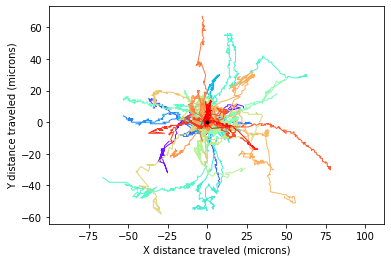

In [34]:
#@markdown ## Plot movie tracks
#@markdown If movie is -1, will plot tracks from all movies
movie = 9#@param{type:"integer"}

#@markdown If you want to plot a range of movies, setting this to a positive number will plot all movies from movie to movie_end
movie_end =  -1#@param{type:"raw"}

#@markdown whether to plot each track in different colors (if false, all will be black);
do_color = True #@param{type:"boolean"}

#@markdown whether to show a legend mapping track id to color
do_legend = False #@param{type:"boolean"}


selected_movies = [];
if movie == -1:
  selected_movies = origin_adjusted_tracks.keys();
elif movie_end and movie_end > 0 and movie_end in origin_adjusted_tracks:
  selected_movies = range(movie,movie_end+1)
elif (movie not in origin_adjusted_tracks):
  raise Exception(f"Error: movie #{movie} not in experimental movies {list(origin_adjusted_tracks.keys())}");
else:
  selected_movies = [movie];
xs = [];
ys = [];
labels = [];
for movie in selected_movies:
  movie_tracks = origin_adjusted_tracks[movie];
  xs += [[t[0] for t in track] for track in movie_tracks.values()];
  ys += [[-t[1] for t in track] for track in movie_tracks.values()];
  if len(selected_movies) == 1:
    labels += [tnum for tnum in movie_tracks.keys()];
  else:
    labels += [f'm{movie}_t{tnum}' for tnum in movie_tracks.keys()];

colors = cm.rainbow(np.linspace(0, 1, len(ys)))
for (x,y,n,c) in zip(xs,ys,labels,colors):
  if do_color:
    plt.plot(x, y, color=c,linewidth=1,label=n);
  else:
    plt.plot(x,y,color = 'black', linewidth=1,label=n);

plt.xlabel(f"X distance traveled ({distance_unit})")
plt.ylabel(f"Y distance traveled ({distance_unit})")
plt.plot(0,0,color= 'black' if do_color else 'red',marker='o',markersize=3);
plt.axis('equal')

if do_legend:
  plt.legend();

fig = plt.gcf();
plt.show();

In [ ]:
#@markdown ## Save plot

#@markdown By default will use the format trackplot_{movie}{-movie_end if not negative}_{no_cell_collection/using_cell_collection}.png

#@markdown whether to override this default behavior and use the specified filename instead: (will be saved in segmentation analysis regardless)
#@markdown "{collection}", "{movie}", and "{movie_end}" will all be available for formatting if custom
do_custom_filename = True #@param{type:"boolean"}
custom_filename = "trackplot_up_{collection}_cell_collection.png" #@param{type:"string"}

filename = custom_filename if do_custom_filename else "trackplot_{movie}" + ("-{movie_end}" if movie_end > 0 else "") + "_{collection}_cell_collection.png";
filename = format_path(filename,collection=track_params['do_cell_collection'],movie=movie,movie_end=movie_end);

fig.savefig(local_analysis_output_folder/filename);
fig.show()

push_analysis();

## Track Gradient Analysis

In [42]:
#@markdown # Input paths to gradients (and fetch from gcp)



#@markdown Folder in gcp where gradients are stored. "{experiment}" will be formatted with the experiment name. Exclude the gs://
gradient_folder = "optotaxisbucket/movies/{experiment}/Gradient Calibration" #@param{type:"string"}
gradient_folder = Path(format_path(gradient_folder,experiment=experiment));

#@markdown Movie numbers are associated with gradient images by their stage position name; stage positions can be extracted from a p.nd file from metamorph. Supported formatting: {experiment}
nd_location = "optotaxisbucket/movies/{experiment}/{experiment}/p.nd" #@param{type:"string"}
nd_location = Path(format_path(nd_location,experiment=experiment));

#@markdown Supported formatting: {experiment}, {stage} (from .nd file or override map) for each position used
gradient_filename = "{stage}.tif" #@param{type:"string"}
gradient_filename = format_path(gradient_filename,experiment=experiment);

#@markdown If the .nd file is unavailable, you can manually map movie numbers to stage position names:
do_override_map = False #@param{type:"boolean"}
try:
  override_map = None #@param{type:"raw"}
except Exception as e:
  print(e)
  override_map = None

def parseND(filePath)->Dict[str,str]:
    with open(filePath,'r') as f:
        lines = f.readlines();
    args = {};
    for line in lines:
        largs = line.rstrip("\n").split(", "); #line args lol
        if largs[0] == '':
          continue;
        if len(largs) == 1 or largs[1] == '':
            if largs[0].startswith("\"EndFile\""):
              break;
            continue;
        args[largs[0].replace("\"","")] = largs[1].replace("\"","");
    return args;

gradient_local = local_folder/"gradients"/experiment
if not gradient_local.exists():
  os.makedirs(gradient_local);
nd_local = temp_folder/"nd"/experiment/(nd_location.name);

!gsutil cp "gs://{nd_location.as_posix()}" "{nd_local.as_posix()}"

nd_data = parseND(nd_local);

stage_map = {i:nd_data[f"Stage{i}"] for i in range(1,int(nd_data["NStagePositions"])+1)}

for name in stage_map.values():
  gf = format_path(gradient_folder/gradient_filename,stage=name)
  print(gf)
  with capture_output():
    !gsutil cp "gs://{gf.as_posix()}" "{gradient_local.as_posix()}/"


Copying gs://optotaxisbucket/movies/2023.1.31 OptoITSN Test 42/2023.1.31 OptoITSN Test 42/p.nd...
/ [1 files][  610.0 B/  610.0 B]                                                
Operation completed over 1 objects/610.0 B.                                      
optotaxisbucket/movies/2023.1.31 OptoITSN Test 42/Gradient Calibration/control1.tif
optotaxisbucket/movies/2023.1.31 OptoITSN Test 42/Gradient Calibration/control2.tif
optotaxisbucket/movies/2023.1.31 OptoITSN Test 42/Gradient Calibration/control3.tif
optotaxisbucket/movies/2023.1.31 OptoITSN Test 42/Gradient Calibration/control4.tif
optotaxisbucket/movies/2023.1.31 OptoITSN Test 42/Gradient Calibration/down1.tif
optotaxisbucket/movies/2023.1.31 OptoITSN Test 42/Gradient Calibration/down2.tif
optotaxisbucket/movies/2023.1.31 OptoITSN Test 42/Gradient Calibration/down3.tif
optotaxisbucket/movies/2023.1.31 OptoITSN Test 42/Gradient Calibration/down4.tif
optotaxisbucket/movies/2023.1.31 OptoITSN Test 42/Gradient Calibration/up1.tif


### Plot Tracks over gradients

In [43]:
#@markdown # Compute Track Points and Gradient 

centertype = track_params['centroidtype'];
centerx = centertype + 'x';
centery = centertype + 'y';


def plot_gradient(movie:int,do_color=True,do_startmarker=True):
  gradient = imread(format_path(gradient_local/gradient_filename,stage=stage_map[movie]));
  plt.imshow(gradient);
  
  trackPoints = {};
  for id,data in progress_bar(sample[movie].items()):
    if not trackStatus[movie][id]:
      continue;
    trackPoints[id] = list(zip(data[centerx],data[centery]));
  
  xs = [[t[0] for t in track] for track in trackPoints.values()];
  ys = [[t[1] for t in track] for track in trackPoints.values()];
  labels = [tnum for tnum in trackPoints.keys()];
  
  colors = cm.rainbow(np.linspace(0, 1, len(ys)))
  for (x,y,n,c) in zip(xs,ys,labels,colors):

    if do_color:
      plt.plot(x, y, color=c,linewidth=1,label=n);
    else:
      plt.plot(x,y,color = 'black', linewidth=1,label=n);

    if do_startmarker:
      # print(x[0],y[0])
      plt.plot(x[-1],y[-1],marker='o',color='black',markersize=2);

  plt.xlabel(f"X distance traveled ({distance_unit})")
  plt.ylabel(f"Y distance traveled ({distance_unit})")
  # plt.plot(0,0,color= 'black' if do_color else 'red',marker='o',markersize=3);
  plt.axis('equal')
  
  fig = plt.gcf();
  return fig;
      


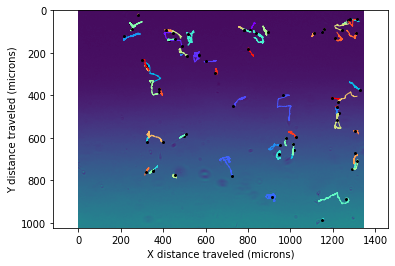

In [45]:
plot_gradient(6).show();

### Export Persistence, Alignment, Velocity with Gradient Steepness, Brightness

In [45]:
#@markdown ## Calculate Frame-by-Frame Metrics with Gradient Steepness X,Y; Intensity

#@markdown ### Flattened save location (in analysis): Combined csv file with every frame from every movie
#@markdown #### Supported formatting: {collection}, {experiment}
flattened_save_location = "gradient_track_flattened_analysis.csv" #@param {"type":"string"}
flattened_save_path = Path(format_path(flattened_save_location,collection=track_params['do_cell_collection'],experiment=experiment))
if flattened_save_path.suffix != ".csv":
  if flattened_save_path.suffix != "":
    print("warning: flattened analysis must be .csv file; changing extension to match");
  flattened_save_path.suffix = ".csv";



#@markdown ### Shaped (python dicts) data save location (in analysis): .pkl file with trackdata organized by movie and track id
#@markdown #### Supported formatting: {collection}, {experiment}
shaped_save_location = "gradient_track_shaped_analysis.pkl" #@param {"type":"string"}
shaped_save_path = Path(format_path(shaped_save_location,collection=track_params['do_cell_collection'],experiment=experiment))
if shaped_save_path.suffix != ".pkl":
  if shaped_save_path.suffix != "":
    print("warning: shaped analysis must be .pkl file; changing extension to match");
  shaped_save_path.suffix = ".pkl";



movies = sample.keys()

centertype = track_params['centroidtype'];
centerx = centertype + 'x';
centery = centertype + 'y';

def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)

def triplewise(iterable):
    "Return overlapping triplets from an iterable"
    # triplewise('ABCDEFG') --> ABC BCD CDE DEF EFG
    for (a, _), (b, c) in pairwise(pairwise(iterable)):
        yield a, b, c


def dist(x1,x2,y1,y2):
  return math.sqrt((x1-x2)**2 + (y1-y2)**2)

def mag(x,y):
  return math.sqrt(x**2+y**2);

shaped_data:Dict[int,Dict[int,pd.DataFrame]] = {}
flattened_data:pd.DataFrame = pd.DataFrame(columns=["movie","frame","trackid","label",centerx,centery,"gradient.x","gradient.y","gradient intensity","velocity.x","velocity.y","speed","persistence","dTheta"])
flat_datalist = [];
parent = master_bar(movies)
for movie in parent:
  #get gradient information
  gradient = imread(format_path(gradient_local/gradient_filename,stage=stage_map[movie]));
  gradient = cv2.GaussianBlur(gradient,(15,15),0);

  xAvg = np.average(gradient,0);
  xX = np.arange(gradient.shape[1])
  xInterpolation = scipy.interpolate.CubicSpline(xX,xAvg)

  yAvg = np.average(gradient,1);
  yX = np.arange(gradient.shape[0])
  yInterpolation = scipy.interpolate.CubicSpline(yX,yAvg)
  
  def grad_xgrad(x,y):
    return xInterpolation(x,1);

  def grad_ygrad(x,y):
    return yInterpolation(y,1);

  def grad_mid(x,y):
    return yInterpolation(y); #THIS IS ASSUMING CONSTANT / SMALL X DEVIATION, ONLY WORKS FOR VERTICAL GRADIENTS


  shaped_data[movie] = {};
  
  ### velocity is from previous frame to current, persistence + dTheta is dP of previous frame and dP of next
  for tid, track in progress_bar(sample[movie].items(),parent=parent):
    if not trackStatus[movie][tid]:
      continue;
    trackData = [];    
    tracklength = track.shape[0]
    # print(tracklength);

    #1st-order (gradient)
    for x,y,(_,frame) in zip(track[centerx],track[centery],track.iterrows()):
      frame = frame.copy();
      frame['gradient.x'] = grad_xgrad(x,y);
      frame['gradient.y'] = grad_ygrad(x,y);
      frame['gradient intensity'] = grad_mid(x,y);
      trackData.append(frame)
    
    #second-order (velocity)
    for frame1,frame2 in pairwise(trackData):
      x1,y1 = frame1[centerx],frame1[centery];
      x2,y2 = frame2[centerx],frame2[centery];

      frame2['velocity.x'] = (x2-x1)*distance_per_pixel/time_per_frame;
      frame2['velocity.y'] = (y2-y1)*distance_per_pixel/time_per_frame;
      frame2['speed'] = dist(x1,x2,y1,y2)*distance_per_pixel/time_per_frame;

    #third-order (persistence, dTheta)
    for frame1,frame2,frame3 in triplewise(trackData):
      x1,y1 = frame1[centerx],frame1[centery];
      x2,y2 = frame2[centerx],frame2[centery];  
      x3,y3 = frame3[centerx],frame3[centery];
      
      v1 = (x2-x1,y2-y1);
      v2 = (x3-x2,y3-y2);
      v3 = (x3-x1,y3-y1);

      disp = mag(*v3);
      l1 = mag(*v1);
      l2 = mag(*v2);
    
      if l1 <= 0.1 or l2 <= 0.1:
        frame2['persistence'] = frame2['dTheta'] = float('nan');

      length = l1 + l2;
      persistence = disp/length if length > 0 else 0;

      frame2['persistence'] = persistence;


      dot = np.dot(v1,v2);
      np.seterr(all='raise')
      lengths = (mag(*v1)*mag(*v2));
      try:
        cos = dot/lengths;
        if abs(cos) <= 1.1: #more fudge factor stuff
          cos = max(-1,min(cos,1));
          print("fudge factoring")
        dTheta = math.acos(cos);
      except:
        print(v1,v2);
        print(dot);
        print(mag(*v1),mag(*v2))
        print(lengths);
        raise Exception()
      frame2['dTheta'] = dTheta;


    trackframe = pd.DataFrame(trackData);
    flat_datalist.append(trackframe);
    shaped_data[movie][tid] = trackframe

flattened_data = pd.concat(flat_datalist);
print(flattened_data);

out = local_analysis_output_folder/flattened_save_path;
out.parent.mkdir(parents=True,exist_ok=True);
flattened_data.to_csv(out);

out = local_analysis_output_folder/shaped_save_path;
out.parent.mkdir(parents=True,exist_ok=True);
with open(out,'wb') as f:
  pickle.dump(out,f);

push_analysis();

    movie  frame  label   area  approximate-medoidx  approximate-medoidy  \
0     1.0    1.0    5.0  356.0               1101.0                128.0   
1     1.0    2.0   10.0  362.0               1101.0                129.0   
2     1.0    3.0    8.0  356.0               1100.0                128.0   
3     1.0    4.0    6.0  351.0               1100.0                128.0   
4     1.0    5.0    5.0  342.0               1099.0                128.0   
..    ...    ...    ...    ...                  ...                  ...   
76   12.0   77.0   -1.0  160.0                309.0               1009.0   
77   12.0   78.0   -1.0  160.0                309.0               1009.0   
78   12.0   79.0   -1.0  160.0                309.0               1009.0   
79   12.0   80.0   -1.0  160.0                309.0               1009.0   
80   12.0   81.0   -1.0  160.0                309.0               1009.0   

               gradient.x            gradient.y  gradient intensity  \
0    0.010333666